In [6]:
# Install required packages (run once in your terminal):
# pip install scipy h5py numpy pandas matplotlib scikit-learn tqdm

import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
import scipy.signal
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
import h5py

warnings.filterwarnings('ignore')

In [7]:
def load_mat_file(filepath):
    """
    Load a .mat file regardless of whether it is MATLAB v5 (scipy)
    or MATLAB v7.3 / HDF5 (h5py).

    Returns a dict-like object with the file's variables.
    """
    try:
        # Try scipy first (works for v4, v5, v6)
        data = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)
        return data, 'scipy'
    except NotImplementedError:
        # Fall back to h5py for v7.3 HDF5-based files
        data = h5py.File(filepath, 'r')
        return data, 'h5py'


def inspect_mat_file(filepath):
    """
    Print all top-level variable names, shapes, and dtypes inside a .mat file.
    Works for both scipy and h5py loaded files.
    """
    data, loader = load_mat_file(filepath)
    print(f"\n{'='*60}")
    print(f"File   : {os.path.basename(filepath)}")
    print(f"Loader : {loader}")
    print(f"{'='*60}")

    if loader == 'scipy':
        for key, val in data.items():
            if key.startswith('_'):          # skip scipy metadata keys
                continue
            if hasattr(val, 'shape'):
                print(f"  [{key}]  shape={val.shape}  dtype={val.dtype}")
            else:
                print(f"  [{key}]  type={type(val).__name__}  value={val}")
    else:
        # h5py: recursively print groups/datasets
        def _print_h5(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  [{name}]  shape={obj.shape}  dtype={obj.dtype}")
        data.visititems(_print_h5)
        data.close()

In [9]:
# ── Paderborn-specific signal extraction ────────────────────────────────────

# Sampling rate is 64 kHz for most files (always verify from your own files)
FS_ORIGINAL = 64_000   # Hz

def get_label_from_filename(filepath):
    """
    Derive a fault-type label from the folder/file name.
    Returns one of: 'healthy', 'outer_artificial', 'inner_artificial',
                    'outer_real', 'inner_real'
    """
    folder = os.path.basename(os.path.dirname(filepath)).upper()
    if folder.startswith('K0'):
        return 'healthy'
    elif folder.startswith('KA'):
        return 'outer_artificial'
    elif folder.startswith('KI') and 'B' not in folder:
        return 'inner_artificial'
    elif folder.startswith('KB'):
        return 'outer_real'
    elif folder.startswith('KIB'):
        return 'inner_real'
    else:
        return 'unknown'


def extract_vibration_scipy(data, filename_key=None):
    """
    Navigate the nested scipy struct to pull out the vibration array.
    The typical path: data[run_key].vibration  (1-D float array)
    """
    # Find the measurement key (not a metadata key)
    run_keys = [k for k in data.keys() if not k.startswith('_')]
    signals = []
    for key in run_keys:
        obj = data[key]
        if hasattr(obj, 'vibration'):
            sig = obj.vibration
            if isinstance(sig, np.ndarray):
                signals.append(sig.ravel().astype(np.float64))
    return signals


def extract_vibration_h5py(filepath):
    """
    Pull vibration data from a v7.3 HDF5 mat file.
    Dereferences MATLAB object arrays as needed.
    """
    signals = []
    with h5py.File(filepath, 'r') as f:
        # Walk every dataset that ends in 'vibration'
        def _grab(name, obj):
            if isinstance(obj, h5py.Dataset) and 'vibration' in name.lower():
                signals.append(np.array(obj).ravel().astype(np.float64))
        f.visititems(_grab)
    return signals


def load_bearing_file(filepath):
    """
    Master loader: returns (list_of_signal_arrays, label_string)
    """
    label = get_label_from_filename(filepath)
    data, loader = load_mat_file(filepath)

    if loader == 'scipy':
        signals = extract_vibration_scipy(data)
    else:
        data.close()          # h5py file was left open — close it
        signals = extract_vibration_h5py(filepath)

    return signals, label

In [18]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
import scipy.signal
import h5py
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

# ── Constants ─────────────────────────────────────────────────────────────────
DATA_ROOT      = r'C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)'
FS_ORIGINAL    = 64_000   # Hz — standard Paderborn sampling rate
FS_TARGET      = 16_000   # Hz — after downsampling


# ════════════════════════════════════════════════════════════════════════════════
# 1. LABEL FUNCTION — matches YOUR folder structure
# ════════════════════════════════════════════════════════════════════════════════

def get_label_from_filepath(filepath):
    """
    Determines fault label from the folder hierarchy:

    archive (6)/
        Healthy data/
            K001/  K002/  K003/  K004/   → 'healthy'
        Unhealthy Data/
            KA***/ → 'outer_race_artificial'
            KB***/ → 'outer_race_real'
            KI***/ → 'inner_race_artificial'   (but NOT KIB)
            KIB**/ → 'inner_race_real'

    Also encodes the specific bearing ID (e.g. K001, KA01) as bearing_id
    so you can do bearing-aware train/test splits later.
    """
    # Normalise to forward slashes for reliable splitting
    norm = filepath.replace('\\', '/')
    parts = norm.split('/')

    # The bearing subfolder is the direct parent of the .mat file
    bearing_folder = parts[-2].upper().strip()   # e.g. 'K001', 'KA01', 'KI21'

    # ── Top-level healthy/unhealthy from grandparent folder ──────────────────
    top_folder = parts[-3].lower().strip()        # 'healthy data' or 'unhealthy data'

    if 'healthy' in top_folder and 'unhealthy' not in top_folder:
        fault_type = 'healthy'

    elif bearing_folder.startswith('KIB'):
        fault_type = 'inner_race_real'

    elif bearing_folder.startswith('KI'):
        fault_type = 'inner_race_artificial'

    elif bearing_folder.startswith('KA'):
        fault_type = 'outer_race_artificial'

    elif bearing_folder.startswith('KB'):
        fault_type = 'outer_race_real'

    else:
        fault_type = 'unknown'

    return fault_type, bearing_folder   # return both for richer metadata


# ════════════════════════════════════════════════════════════════════════════════
# 2. .MAT FILE LOADER  (handles both scipy v5 and h5py v7.3)
# ════════════════════════════════════════════════════════════════════════════════

def load_mat_file(filepath):
    try:
        data = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)
        return data, 'scipy'
    except NotImplementedError:
        data = h5py.File(filepath, 'r')
        return data, 'h5py'


def inspect_mat_file(filepath):
    """Print all variables, shapes and dtypes inside a .mat file."""
    data, loader = load_mat_file(filepath)
    print(f"\n{'='*60}")
    print(f"File  : {os.path.basename(filepath)}")
    print(f"Loader: {loader}")
    print(f"{'='*60}")

    if loader == 'scipy':
        for key, val in data.items():
            if key.startswith('_'):
                continue
            if hasattr(val, 'shape'):
                print(f"  [{key}]  shape={val.shape}  dtype={val.dtype}")
            else:
                print(f"  [{key}]  type={type(val).__name__}")
    else:
        def _print(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  [{name}]  shape={obj.shape}  dtype={obj.dtype}")
        data.visititems(_print)
        data.close()


def extract_vibration_scipy(data):
    """Pull vibration arrays out of a scipy-loaded Paderborn struct."""
    signals = []
    run_keys = [k for k in data.keys() if not k.startswith('_')]
    for key in run_keys:
        obj = data[key]
        # The Paderborn struct path is: <run_key>.vibration
        if hasattr(obj, 'vibration'):
            sig = obj.vibration
            if isinstance(sig, np.ndarray) and sig.ndim >= 1:
                signals.append(sig.ravel().astype(np.float64))
    return signals


def extract_vibration_h5py(filepath):
    """Pull vibration arrays out of a v7.3 HDF5 .mat file."""
    signals = []
    with h5py.File(filepath, 'r') as f:
        def _grab(name, obj):
            if isinstance(obj, h5py.Dataset) and 'vibration' in name.lower():
                signals.append(np.array(obj).ravel().astype(np.float64))
        f.visititems(_grab)
    return signals


def load_bearing_file(filepath):
    """
    Master loader. Returns (list_of_signal_arrays, fault_type, bearing_id).
    """
    fault_type, bearing_id = get_label_from_filepath(filepath)
    data, loader = load_mat_file(filepath)

    if loader == 'scipy':
        signals = extract_vibration_scipy(data)
    else:
        data.close()
        signals = extract_vibration_h5py(filepath)

    return signals, fault_type, bearing_id


# ════════════════════════════════════════════════════════════════════════════════
# 3. INVENTORY BUILDER
# ════════════════════════════════════════════════════════════════════════════════

def build_file_inventory(root_dir):
    root_dir = os.path.abspath(root_dir)

    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    records = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith('.mat'):
                fpath = os.path.join(dirpath, fname)
                fault_type, bearing_id = get_label_from_filepath(fpath)
                records.append({
                    'filepath':   fpath,
                    'filename':   fname,
                    'label':      fault_type,
                    'bearing_id': bearing_id,
                })

    if not records:
        raise ValueError(f"No .mat files found under {root_dir}")

    df = pd.DataFrame(records)

    print(f"✓ Found {len(df)} .mat files\n")
    print("── By fault type ──────────────────────────")
    print(df['label'].value_counts().to_string())
    print("\n── By bearing ID ──────────────────────────")
    print(df['bearing_id'].value_counts().to_string())

    # Warn about any unrecognised folders
    unknown = df[df['label'] == 'unknown']
    if len(unknown):
        print(f"\n[WARNING] {len(unknown)} files labelled 'unknown':")
        for _, r in unknown.iterrows():
            print(f"  {r['filepath']}")

    return df


inventory = build_file_inventory(DATA_ROOT)

✓ Found 2560 .mat files

── By fault type ──────────────────────────
label
outer_race_artificial    960
inner_race_artificial    880
healthy                  480
outer_race_real          240

── By bearing ID ──────────────────────────
bearing_id
K001    80
K002    80
K003    80
K004    80
K005    80
K006    80
KA01    80
KA03    80
KA04    80
KA05    80
KA06    80
KA07    80
KA08    80
KA09    80
KA15    80
KA16    80
KA22    80
KA30    80
KB23    80
KB24    80
KB27    80
KI01    80
KI03    80
KI04    80
KI05    80
KI07    80
KI08    80
KI14    80
KI16    80
KI17    80
KI18    80
KI21    80


In [19]:
# Pick one file from each label and make sure signals load correctly
for label in inventory['label'].unique():
    sample = inventory[inventory['label'] == label].iloc[0]
    signals, fault_type, bearing_id = load_bearing_file(sample['filepath'])
    print(f"Label: {fault_type:<25s}  "
          f"Bearing: {bearing_id:<8s}  "
          f"Runs in file: {len(signals)}  "
          f"Samples per run: {len(signals[0]) if signals else 'NO SIGNAL FOUND'}")

Label: healthy                    Bearing: K001      Runs in file: 0  Samples per run: NO SIGNAL FOUND
Label: outer_race_artificial      Bearing: KA01      Runs in file: 0  Samples per run: NO SIGNAL FOUND
Label: outer_race_real            Bearing: KB23      Runs in file: 0  Samples per run: NO SIGNAL FOUND
Label: inner_race_artificial      Bearing: KI01      Runs in file: 0  Samples per run: NO SIGNAL FOUND


In [20]:
import scipy.io
import numpy as np

# Pick one file to dissect
sample_file = inventory[inventory['label'] == 'healthy']['filepath'].iloc[0]
print("Inspecting:", sample_file)

data = scipy.io.loadmat(sample_file, squeeze_me=True, struct_as_record=False)

# Step 1: print all top-level keys
print("\n── Top-level keys ──────────────────────────────────────")
for key in data.keys():
    val = data[key]
    if hasattr(val, 'shape'):
        print(f"  '{key}'  →  shape={val.shape}  dtype={val.dtype}")
    else:
        print(f"  '{key}'  →  type={type(val).__name__}  value={repr(val)[:80]}")

Inspecting: C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data\K001\N09_M07_F10_K001_1.mat

── Top-level keys ──────────────────────────────────────
  '__header__'  →  type=bytes  value=b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Sep 17 19:51:48 2015'
  '__version__'  →  type=str  value='1.0'
  '__globals__'  →  type=list  value=[]
  'N09_M07_F10_K001_1'  →  type=mat_struct  value=<scipy.io.matlab._mio5_params.mat_struct object at 0x000002EBEEBEE4E0>


In [21]:
# Step 2: for every non-metadata key, explore one level deeper
print("\n── Drilling into struct fields ─────────────────────────")
for key in data.keys():
    if key.startswith('_'):
        continue
    obj = data[key]
    print(f"\n  Key: '{key}'  type={type(obj).__name__}")
    
    # If it's a mat_struct, list its fields
    if hasattr(obj, '_fieldnames'):
        print(f"    _fieldnames: {obj._fieldnames}")
        for field in obj._fieldnames:
            child = getattr(obj, field)
            if hasattr(child, 'shape'):
                print(f"      .{field}  →  shape={child.shape}  dtype={child.dtype}")
            elif hasattr(child, '_fieldnames'):
                print(f"      .{field}  →  nested struct, fields={child._fieldnames}")
            else:
                print(f"      .{field}  →  type={type(child).__name__}  value={repr(child)[:60]}")
    
    # If it's a numpy array of objects (array of structs)
    elif isinstance(obj, np.ndarray) and obj.dtype == object:
        print(f"    shape={obj.shape}  dtype=object (array of structs)")
        # inspect first element
        first = obj.flat[0]
        print(f"    first element type={type(first).__name__}")
        if hasattr(first, '_fieldnames'):
            print(f"    first element fields={first._fieldnames}")
            for field in first._fieldnames:
                child = getattr(first, field)
                if hasattr(child, 'shape'):
                    print(f"      .{field}  →  shape={child.shape}  dtype={child.dtype}")
                elif hasattr(child, '_fieldnames'):
                    print(f"      .{field}  →  nested struct, fields={child._fieldnames}")
                else:
                    print(f"      .{field}  →  type={type(child).__name__}  value={repr(child)[:60]}")

    elif isinstance(obj, np.ndarray):
        print(f"    shape={obj.shape}  dtype={obj.dtype}")


── Drilling into struct fields ─────────────────────────

  Key: 'N09_M07_F10_K001_1'  type=mat_struct
    _fieldnames: ['Info', 'X', 'Y', 'Description']
      .Info  →  nested struct, fields=['RevisionMajor', 'RevisionMinor', 'MeasurementID']
      .X  →  shape=(3,)  dtype=object
      .Y  →  shape=(7,)  dtype=object
      .Description  →  nested struct, fields=['General', 'Recording', 'Measurement']


In [22]:
# Step 3: if there's a 'bearing' or similar nested struct, go deeper
print("\n── Deep dive: looking for numeric arrays ───────────────")

def recursive_explore(obj, path="", depth=0):
    """Recursively walk a mat_struct and print all numeric arrays found."""
    if depth > 5:
        return
    indent = "  " * depth
    
    if hasattr(obj, '_fieldnames'):
        for field in obj._fieldnames:
            child = getattr(obj, field)
            recursive_explore(child, path=f"{path}.{field}", depth=depth+1)
    
    elif isinstance(obj, np.ndarray):
        if obj.dtype == object:
            # array of structs — inspect first element
            if obj.size > 0:
                recursive_explore(obj.flat[0], path=f"{path}[0]", depth=depth+1)
        else:
            # actual numeric data — this is what we want!
            print(f"  ✓ NUMERIC ARRAY at '{path}'  shape={obj.shape}  dtype={obj.dtype}")

for key in data.keys():
    if not key.startswith('_'):
        recursive_explore(data[key], path=key, depth=0)


── Deep dive: looking for numeric arrays ───────────────
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.X[0].Name'  shape=(0,)  dtype=<U1
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.X[0].Data'  shape=(16008,)  dtype=float64
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.X[0].Unit'  shape=(0,)  dtype=<U1
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.Y[0].Data'  shape=(16008,)  dtype=float64
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.Y[0].Unit'  shape=(0,)  dtype=<U1
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.Y[0].Description'  shape=(0,)  dtype=<U1
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.Y[0].DisplayIdentifier'  shape=(0,)  dtype=<U1
  ✓ NUMERIC ARRAY at 'N09_M07_F10_K001_1.Description.General.Description'  shape=(0,)  dtype=<U1


In [23]:
# Check how many channels are in Y (could be vibration + current)
sample_file = inventory[inventory['label'] == 'healthy']['filepath'].iloc[0]
data = scipy.io.loadmat(sample_file, squeeze_me=True, struct_as_record=False)

# Get the run key (the filename without extension)
run_key = [k for k in data.keys() if not k.startswith('_')][0]
obj = data[run_key]

print(f"Run key: '{run_key}'")
print(f"Y array length (number of channels): {len(obj.Y)}")
print(f"X array length                      : {len(obj.X)}")

print("\n── All Y channels ──────────────────────────────────────")
for i, ch in enumerate(obj.Y):
    name  = str(ch.Name)        if hasattr(ch, 'Name')        else 'N/A'
    desc  = str(ch.Description) if hasattr(ch, 'Description') else 'N/A'
    disp  = str(ch.DisplayIdentifier) if hasattr(ch, 'DisplayIdentifier') else 'N/A'
    unit  = str(ch.Unit)        if hasattr(ch, 'Unit')        else 'N/A'
    shape = ch.Data.shape       if hasattr(ch, 'Data')        else 'N/A'
    print(f"  Y[{i}]  Name='{name}'  DisplayIdentifier='{disp}'  "
          f"Unit='{unit}'  Data.shape={shape}")

print("\n── X channel (time axis) ───────────────────────────────")
for i, ch in enumerate(obj.X):
    name  = str(ch.Name) if hasattr(ch, 'Name') else 'N/A'
    unit  = str(ch.Unit) if hasattr(ch, 'Unit') else 'N/A'
    shape = ch.Data.shape if hasattr(ch, 'Data') else 'N/A'
    print(f"  X[{i}]  Name='{name}'  Unit='{unit}'  Data.shape={shape}")

Run key: 'N09_M07_F10_K001_1'
Y array length (number of channels): 7
X array length                      : 3

── All Y channels ──────────────────────────────────────
  Y[0]  Name='force'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(16008,)
  Y[1]  Name='phase_current_1'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(256823,)
  Y[2]  Name='phase_current_2'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(256823,)
  Y[3]  Name='speed'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(16008,)
  Y[4]  Name='temp_2_bearing_module'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(5,)
  Y[5]  Name='torque'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(16008,)
  Y[6]  Name='vibration_1'  DisplayIdentifier='[]'  Unit='[]'  Data.shape=(256823,)

── X channel (time axis) ───────────────────────────────
  X[0]  Name='[]'  Unit='[]'  Data.shape=(16008,)
  X[1]  Name='[]'  Unit='[]'  Data.shape=(256823,)
  X[2]  Name='[]'  Unit='[]'  Data.shape=(5,)


In [25]:
# ════════════════════════════════════════════════════════════════════════════════
# STEP 1: Inspect channels in one file
# ════════════════════════════════════════════════════════════════════════════════

sample_file = inventory[inventory['label'] == 'healthy']['filepath'].iloc[0]
data = scipy.io.loadmat(sample_file, squeeze_me=True, struct_as_record=False)

run_key = [k for k in data.keys() if not k.startswith('_')][0]
obj = data[run_key]

print(f"Run key: '{run_key}'")
print(f"Y channels: {len(obj.Y)}")
print(f"X channels: {len(obj.X)}")

print("\n── All Y channels ──────────────────────────────────────")
for i, ch in enumerate(obj.Y):
    name  = str(ch.Name)              if hasattr(ch, 'Name')              else 'N/A'
    disp  = str(ch.DisplayIdentifier) if hasattr(ch, 'DisplayIdentifier') else 'N/A'
    unit  = str(ch.Unit)              if hasattr(ch, 'Unit')              else 'N/A'
    shape = ch.Data.shape             if hasattr(ch, 'Data')              else 'N/A'
    print(f"  Y[{i}]  Name='{name}'  DisplayIdentifier='{disp}'  Unit='{unit}'  shape={shape}")

print("\n── X channel ───────────────────────────────────────────")
for i, ch in enumerate(obj.X):
    unit  = str(ch.Unit)  if hasattr(ch, 'Unit')  else 'N/A'
    shape = ch.Data.shape if hasattr(ch, 'Data')  else 'N/A'
    print(f"  X[{i}]  Unit='{unit}'  shape={shape}")

Run key: 'N09_M07_F10_K001_1'
Y channels: 7
X channels: 3

── All Y channels ──────────────────────────────────────
  Y[0]  Name='force'  DisplayIdentifier='[]'  Unit='[]'  shape=(16008,)
  Y[1]  Name='phase_current_1'  DisplayIdentifier='[]'  Unit='[]'  shape=(256823,)
  Y[2]  Name='phase_current_2'  DisplayIdentifier='[]'  Unit='[]'  shape=(256823,)
  Y[3]  Name='speed'  DisplayIdentifier='[]'  Unit='[]'  shape=(16008,)
  Y[4]  Name='temp_2_bearing_module'  DisplayIdentifier='[]'  Unit='[]'  shape=(5,)
  Y[5]  Name='torque'  DisplayIdentifier='[]'  Unit='[]'  shape=(16008,)
  Y[6]  Name='vibration_1'  DisplayIdentifier='[]'  Unit='[]'  shape=(256823,)

── X channel ───────────────────────────────────────────
  X[0]  Unit='[]'  shape=(16008,)
  X[1]  Unit='[]'  shape=(256823,)
  X[2]  Unit='[]'  shape=(5,)


In [26]:
# ════════════════════════════════════════════════════════════════════════════════
# CORRECTED EXTRACTION — targets Y[6] vibration_1
# ════════════════════════════════════════════════════════════════════════════════

VIBRATION_CHANNEL = 6   # Y[6] = 'vibration_1'
TIME_AXIS_IDX     = 1   # X[1] corresponds to 256823-sample signals

def extract_vibration_scipy(data):
    """
    Extract vibration_1 (Y[6]) from each run in a scipy-loaded Paderborn file.
    Returns list of dicts with signal, fs, and metadata.
    """
    results  = []
    run_keys = [k for k in data.keys() if not k.startswith('_')]

    for run_key in run_keys:
        obj = data[run_key]

        # ── Infer sampling rate from X[1] (the high-rate time axis) ──────────
        try:
            time_vec  = obj.X[TIME_AXIS_IDX].Data.ravel().astype(np.float64)
            fs_actual = round(1.0 / float(np.median(np.diff(time_vec))))
        except Exception:
            fs_actual = FS_ORIGINAL   # fallback to 64000

        # ── Extract vibration_1 from Y[6] ────────────────────────────────────
        try:
            vib_ch = obj.Y[VIBRATION_CHANNEL]
            assert vib_ch.Name == 'vibration_1', \
                f"Expected vibration_1 at Y[{VIBRATION_CHANNEL}], got '{vib_ch.Name}'"
            sig = vib_ch.Data.ravel().astype(np.float64)
        except Exception as e:
            print(f"  [WARN] Could not extract vibration from '{run_key}': {e}")
            continue

        # ── Optionally also grab phase currents ───────────────────────────────
        try:
            cur1 = obj.Y[1].Data.ravel().astype(np.float64)
            cur2 = obj.Y[2].Data.ravel().astype(np.float64)
        except Exception:
            cur1 = cur2 = None

        results.append({
            'signal':   sig,
            'current1': cur1,
            'current2': cur2,
            'fs':       fs_actual,
            'run_key':  run_key,
        })

    return results


def extract_vibration_h5py(filepath):
    """Fallback for v7.3 HDF5 files — searches for the vibration_1 dataset."""
    results = []
    with h5py.File(filepath, 'r') as f:
        def _grab(name, obj):
            if isinstance(obj, h5py.Dataset) and 'vibration' in name.lower():
                arr = np.array(obj).ravel().astype(np.float64)
                if len(arr) > 1000:
                    results.append({
                        'signal':   arr,
                        'current1': None,
                        'current2': None,
                        'fs':       FS_ORIGINAL,
                        'run_key':  name,
                    })
        f.visititems(_grab)
    return results


def load_bearing_file(filepath):
    """
    Master loader.
    Returns (list_of_result_dicts, fault_type, bearing_id)
    Each dict: {signal, current1, current2, fs, run_key}
    """
    fault_type, bearing_id = get_label_from_filepath(filepath)
    data, loader = load_mat_file(filepath)

    if loader == 'scipy':
        results = extract_vibration_scipy(data)
    else:
        data.close()
        results = extract_vibration_h5py(filepath)

    return results, fault_type, bearing_id

In [27]:
# ════════════════════════════════════════════════════════════════════════════════
# VERIFY — one file per label
# ════════════════════════════════════════════════════════════════════════════════

print(f"{'Label':<25s}  {'Bearing':<8s}  {'Runs':>4s}  "
      f"{'Samples':>8s}  {'fs (Hz)':>8s}  {'Duration':>9s}")
print("─" * 75)

for label in inventory['label'].unique():
    sample = inventory[inventory['label'] == label].iloc[0]
    results, fault_type, bearing_id = load_bearing_file(sample['filepath'])

    if results:
        r        = results[0]
        duration = len(r['signal']) / r['fs']
        print(f"  {fault_type:<25s}  {bearing_id:<8s}  {len(results):>4d}  "
              f"{len(r['signal']):>8d}  {r['fs']:>8d}  {duration:>8.3f}s")
    else:
        print(f"  {fault_type:<25s}  {bearing_id:<8s}  NO SIGNAL EXTRACTED")

Label                      Bearing   Runs   Samples   fs (Hz)   Duration
───────────────────────────────────────────────────────────────────────────
  healthy                    K001         1    256823     64943     3.955s
  outer_race_artificial      KA01         1    256001     63188     4.051s
  outer_race_real            KB23         1    256001     63188     4.051s
  inner_race_artificial      KI01         1    256001     63188     4.051s


In [28]:
# ════════════════════════════════════════════════════════════════════════════════
# CONSTANTS — updated to reflect actual fs range
# ════════════════════════════════════════════════════════════════════════════════

FS_TARGET = 16_000   # Hz — keeps 0–8 kHz, well above all bearing fault harmonics

# ════════════════════════════════════════════════════════════════════════════════
# DOWNSAMPLING
# Using resample_poly: FIR anti-alias filter, handles non-integer ratios cleanly
# We compute up/down per file since fs varies (64943 vs 63188)
# ════════════════════════════════════════════════════════════════════════════════

from math import gcd

def downsample_signal(signal, fs_orig, fs_target=FS_TARGET):
    """
    Downsample signal from fs_orig to fs_target using polyphase resampling.
    Automatically handles non-integer ratios by reducing the up/down fraction.

    resample_poly is preferred here because:
      - Uses a linear-phase FIR anti-alias filter (no phase distortion)
      - Handles non-integer ratios via rational up/down fractions
      - More numerically stable than decimate for large factors
      - Faster and lower memory than FFT-based resample for long signals
    """
    # Round both rates to nearest integer then reduce fraction
    up   = int(fs_target)
    down = int(fs_orig)
    common = gcd(up, down)
    up   = up   // common
    down = down // common

    return scipy.signal.resample_poly(signal, up, down)

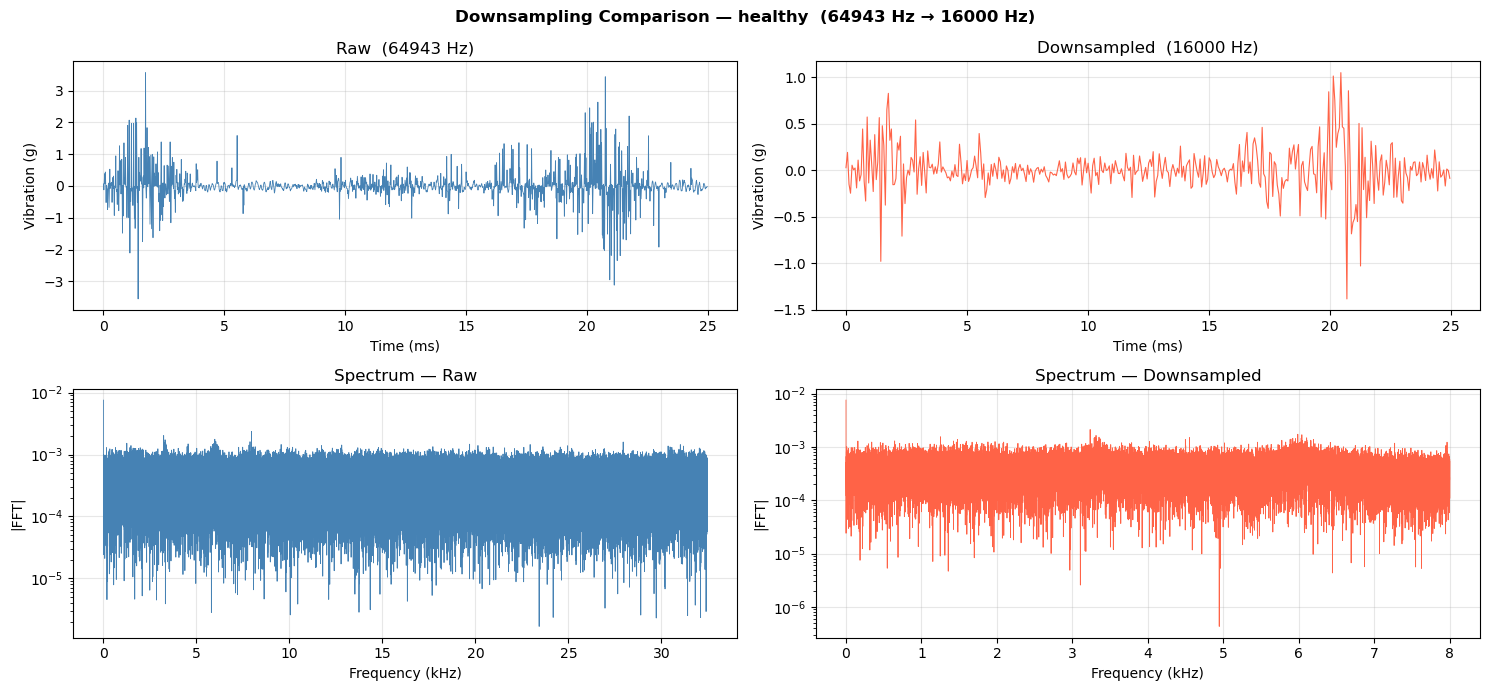

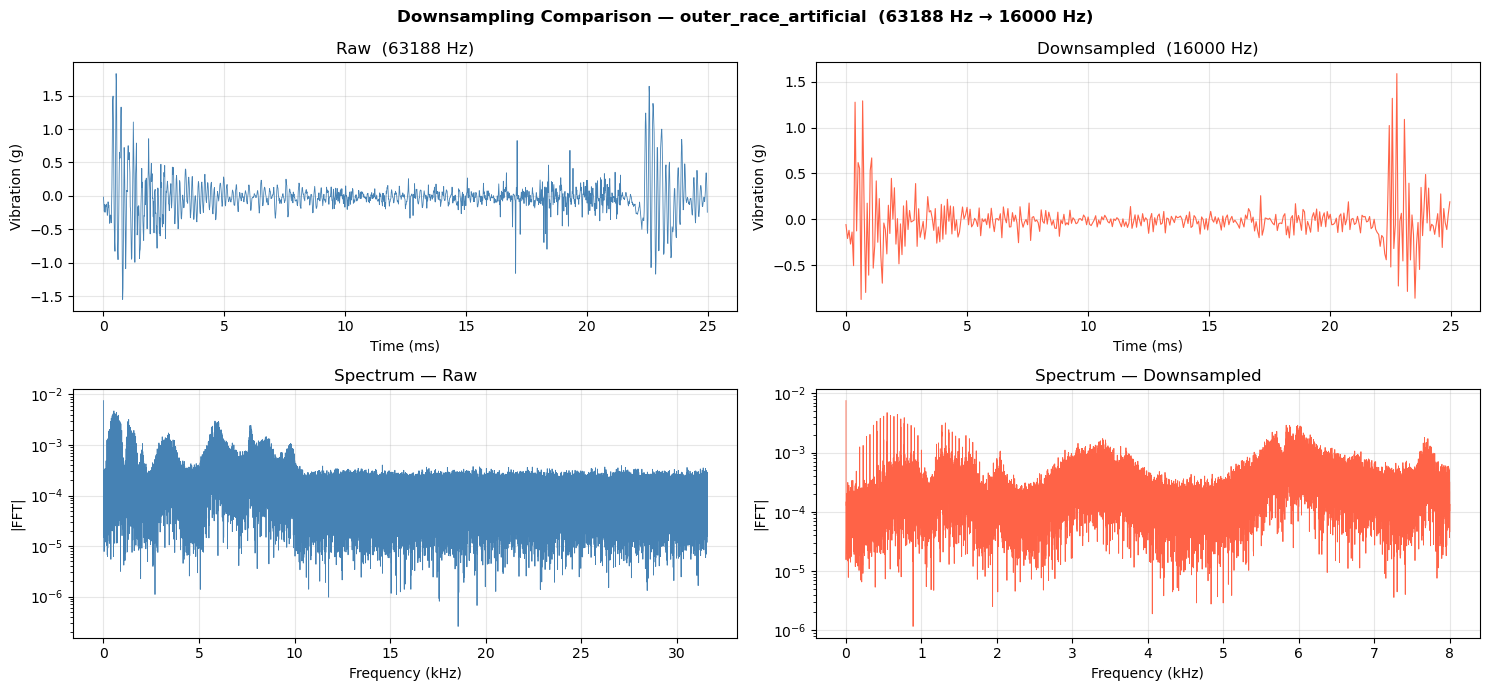

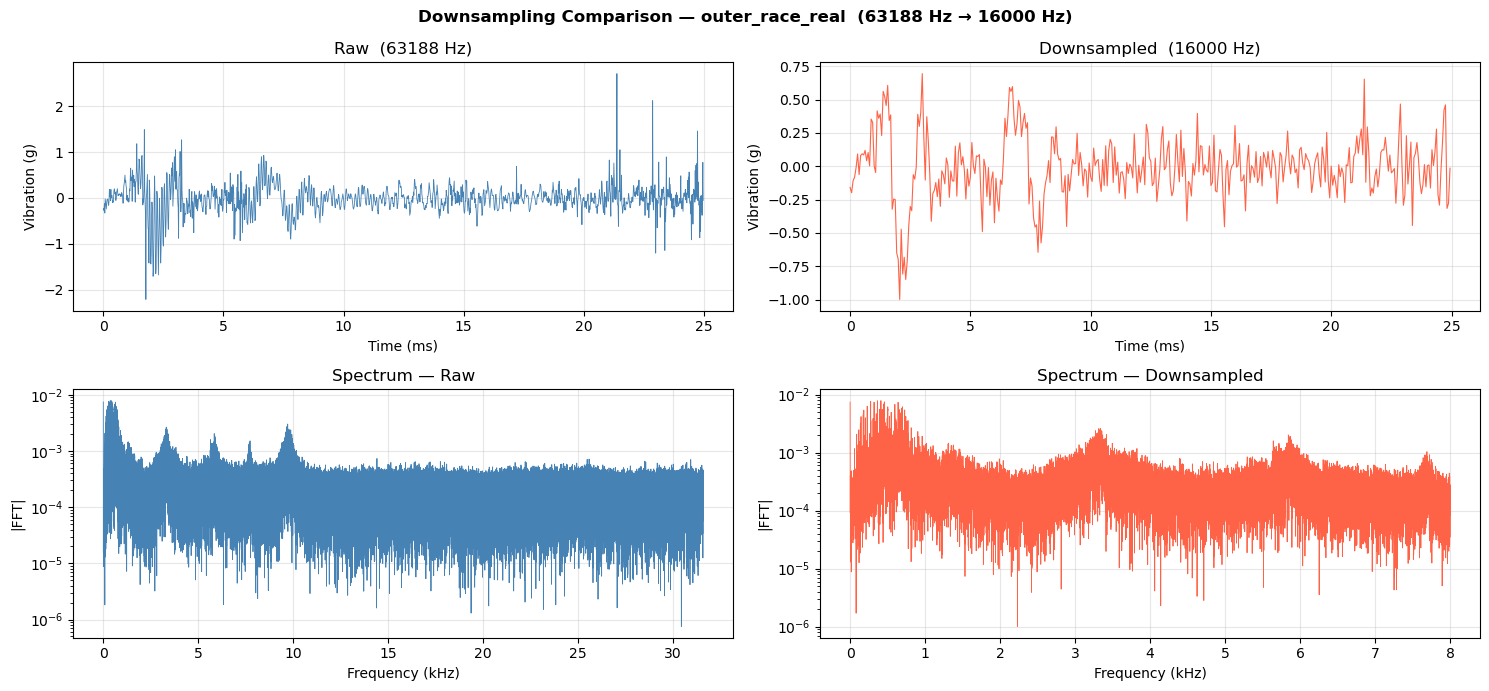

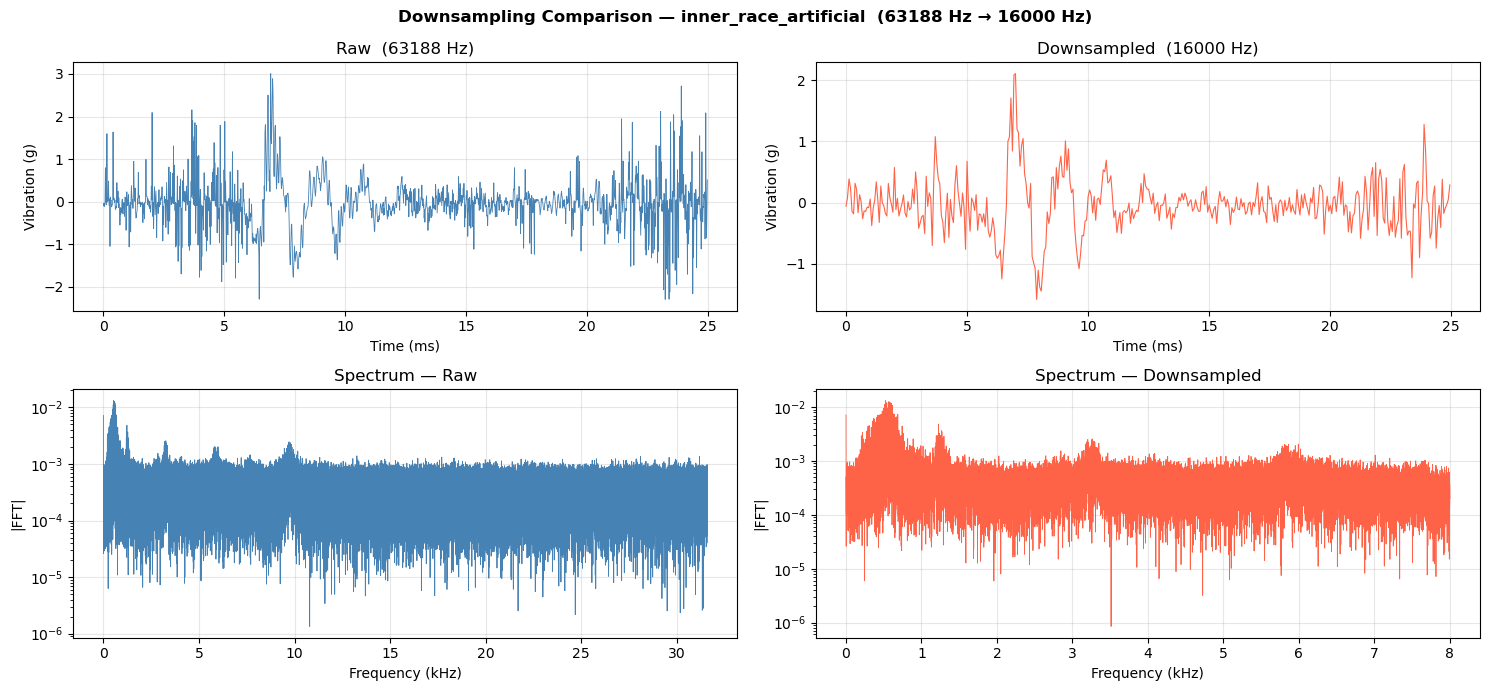

In [29]:
# ════════════════════════════════════════════════════════════════════════════════
# VISUALISE — raw vs downsampled for each label
# ════════════════════════════════════════════════════════════════════════════════

def plot_downsample_comparison(signal, fs_orig, fs_target=FS_TARGET,
                               label='', n_ms=25):
    sig_ds = downsample_signal(signal, fs_orig, fs_target)

    n_raw = int(n_ms / 1000 * fs_orig)
    n_ds  = int(n_ms / 1000 * fs_target)

    fig, axes = plt.subplots(2, 2, figsize=(15, 7))
    fig.suptitle(f'Downsampling Comparison — {label}  '
                 f'({fs_orig:.0f} Hz → {fs_target} Hz)',
                 fontsize=12, fontweight='bold')

    # Time domain — raw
    t_raw = np.arange(n_raw) / fs_orig * 1000
    axes[0, 0].plot(t_raw, signal[:n_raw], lw=0.6, color='steelblue')
    axes[0, 0].set(title=f'Raw  ({fs_orig:.0f} Hz)',
                   xlabel='Time (ms)', ylabel='Vibration (g)')
    axes[0, 0].grid(alpha=0.3)

    # Time domain — downsampled
    t_ds = np.arange(n_ds) / fs_target * 1000
    axes[0, 1].plot(t_ds, sig_ds[:n_ds], lw=0.8, color='tomato')
    axes[0, 1].set(title=f'Downsampled  ({fs_target} Hz)',
                   xlabel='Time (ms)', ylabel='Vibration (g)')
    axes[0, 1].grid(alpha=0.3)

    # Spectrum — raw
    def plot_spectrum(ax, sig, fs, color, title):
        N   = len(sig)
        mag = np.abs(np.fft.rfft(sig * np.hanning(N))) / N
        f   = np.fft.rfftfreq(N, d=1.0/fs) / 1000   # kHz
        ax.semilogy(f, mag + 1e-12, lw=0.6, color=color)
        ax.set(title=title, xlabel='Frequency (kHz)', ylabel='|FFT|')
        ax.grid(alpha=0.3)

    plot_spectrum(axes[1, 0], signal,  fs_orig,   'steelblue', 'Spectrum — Raw')
    plot_spectrum(axes[1, 1], sig_ds,  fs_target, 'tomato',    'Spectrum — Downsampled')

    plt.tight_layout()
    plt.show()
    return sig_ds


# Plot one example per class
for label in inventory['label'].unique():
    sample = inventory[inventory['label'] == label].iloc[0]
    results, fault_type, _ = load_bearing_file(sample['filepath'])
    if results:
        r = results[0]
        plot_downsample_comparison(r['signal'], r['fs'],
                                   label=fault_type, n_ms=25)

In [30]:
# ════════════════════════════════════════════════════════════════════════════════
# FEATURE EXTRACTION
# ════════════════════════════════════════════════════════════════════════════════

from scipy.stats import kurtosis, skew

def time_domain_features(sig):
    sig   = sig.astype(np.float64)
    rms   = np.sqrt(np.mean(sig ** 2))
    peak  = np.max(np.abs(sig))
    mean_abs = np.mean(np.abs(sig)) + 1e-12

    return {
        'mean':           np.mean(sig),
        'std':            np.std(sig),
        'rms':            rms,
        'peak':           peak,
        'peak_to_peak':   np.ptp(sig),
        'crest_factor':   peak / (rms + 1e-12),
        'shape_factor':   rms / mean_abs,
        'impulse_factor': peak / mean_abs,
        'kurtosis':       kurtosis(sig),      # >3 indicates impulsive faults
        'skewness':       skew(sig),
        'variance':       np.var(sig),
    }


def frequency_domain_features(sig, fs, n_bands=8):
    N      = len(sig)
    window = np.hanning(N)
    mag    = np.abs(np.fft.rfft(sig * window)) / N
    freqs  = np.fft.rfftfreq(N, d=1.0/fs)
    psd    = mag ** 2
    psd_sum = np.sum(psd) + 1e-12

    # Spectral moments
    sc  = np.sum(freqs * psd) / psd_sum                                # centroid
    sv  = np.sum(((freqs - sc) ** 2) * psd) / psd_sum                 # variance
    sk_ = np.sum(((freqs - sc) ** 4) * psd) / (psd_sum * (sv**2 + 1e-12))  # kurtosis
    se  = -np.sum((psd / psd_sum) * np.log(psd / psd_sum + 1e-12))    # entropy

    feats = {
        'spectral_centroid':  sc,
        'spectral_variance':  sv,
        'spectral_kurtosis':  sk_,
        'spectral_entropy':   se,
    }

    # Equal-width band power features
    band_edges = np.linspace(0, fs / 2, n_bands + 1)
    for i in range(n_bands):
        mask = (freqs >= band_edges[i]) & (freqs < band_edges[i + 1])
        feats[f'band_{i+1}_power'] = float(np.sum(psd[mask]))

    return feats


def envelope_features(sig, fs):
    """
    Hilbert envelope spectrum — captures amplitude modulation caused by
    bearing fault impulses repeating at characteristic defect frequencies.
    """
    envelope  = np.abs(scipy.signal.hilbert(sig))
    env_fft   = np.abs(np.fft.rfft(envelope)) / len(envelope)
    env_freqs = np.fft.rfftfreq(len(envelope), d=1.0/fs)

    # Energy in typical bearing defect frequency range 50–2000 Hz
    mask = (env_freqs >= 50) & (env_freqs <= 2000)

    return {
        'envelope_mean':        float(np.mean(envelope)),
        'envelope_std':         float(np.std(envelope)),
        'envelope_kurtosis':    float(kurtosis(envelope)),
        'envelope_fault_energy':float(np.sum(env_fft[mask] ** 2)),
    }


def extract_all_features(sig, fs):
    feats = {}
    feats.update(time_domain_features(sig))
    feats.update(frequency_domain_features(sig, fs))
    feats.update(envelope_features(sig, fs))
    return feats

In [31]:
# ════════════════════════════════════════════════════════════════════════════════
# BUILD FULL FEATURE MATRIX
# Segments each signal into 1-second windows, extracts features from each
# ════════════════════════════════════════════════════════════════════════════════

def process_dataset(inventory_df,
                    fs_target=FS_TARGET,
                    segment_length_s=1.0,
                    max_segments_per_file=4):
    """
    For every .mat file:
      1. Load vibration signal
      2. Downsample to fs_target using actual per-file fs
      3. Slice into fixed-length non-overlapping windows
      4. Extract features from each window

    max_segments_per_file=4 keeps classes balanced
    (4 segs × ~80 files per class = ~320 rows per class)
    """
    seg_samples = int(segment_length_s * fs_target)
    all_rows    = []

    for _, row in tqdm(inventory_df.iterrows(),
                       total=len(inventory_df), desc='Extracting features'):
        try:
            results, fault_type, bearing_id = load_bearing_file(row['filepath'])
        except Exception as e:
            print(f"  [WARN] Load failed: {row['filepath']} — {e}")
            continue

        if not results:
            continue

        r      = results[0]                  # one run per file
        sig_ds = downsample_signal(r['signal'], r['fs'], fs_target)

        n_segs = min(len(sig_ds) // seg_samples, max_segments_per_file)

        for s in range(n_segs):
            segment = sig_ds[s * seg_samples:(s + 1) * seg_samples]
            feats   = extract_all_features(segment, fs=fs_target)

            feats['label']      = fault_type
            feats['bearing_id'] = bearing_id
            feats['filepath']   = row['filepath']
            feats['segment_id'] = s
            all_rows.append(feats)

    feature_df = pd.DataFrame(all_rows)
    print(f"\nFeature matrix shape : {feature_df.shape}")
    print(f"Segments per class   :")
    print(feature_df['label'].value_counts().to_string())
    return feature_df


feature_df = process_dataset(inventory)

Extracting features:  39%|███▉      | 993/2560 [01:21<03:07,  8.38it/s]

  [WARN] Load failed: C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Unhealthy Data\KA08\N15_M01_F10_KA08_2.mat — Expecting matrix here


Extracting features: 100%|██████████| 2560/2560 [02:58<00:00, 14.33it/s]


Feature matrix shape : (10139, 31)
Segments per class   :
label
outer_race_artificial    3831
inner_race_artificial    3495
healthy                  1873
outer_race_real           940


In [32]:
# ════════════════════════════════════════════════════════════════════════════════
# FEATURE SELECTION — mutual information ranking
# ════════════════════════════════════════════════════════════════════════════════

from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble         import RandomForestClassifier
from sklearn.model_selection  import StratifiedGroupKFold, cross_val_score
from sklearn.pipeline         import Pipeline

META_COLS = ['label', 'bearing_id', 'filepath', 'segment_id']
feat_cols = [c for c in feature_df.columns if c not in META_COLS]

le = LabelEncoder()
y  = le.fit_transform(feature_df['label'])
X  = feature_df[feat_cols].fillna(0).values.astype(np.float32)

print(f"X shape : {X.shape}")
print(f"Classes : {dict(enumerate(le.classes_))}")

# Rank features by mutual information
mi     = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_ser = pd.Series(mi, index=feat_cols).sort_values(ascending=False)

print("\nTop 15 features by mutual information:")
print(mi_ser.head(15).to_string())

# Keep top 15
top_features = mi_ser.head(15).index.tolist()
X_selected   = feature_df[top_features].fillna(0).values.astype(np.float32)

X shape : (10139, 27)
Classes : {0: 'healthy', 1: 'inner_race_artificial', 2: 'outer_race_artificial', 3: 'outer_race_real'}

Top 15 features by mutual information:
envelope_std             0.570671
std                      0.506368
variance                 0.506324
envelope_fault_energy    0.487143
band_1_power             0.479827
rms                      0.478037
envelope_mean            0.421404
band_5_power             0.338857
band_6_power             0.329875
band_2_power             0.304601
spectral_centroid        0.301341
band_4_power             0.298549
spectral_entropy         0.283118
band_3_power             0.277433
mean                     0.270438


In [33]:
# ════════════════════════════════════════════════════════════════════════════════
# MODEL EVALUATION
# Uses StratifiedGroupKFold so segments from the same bearing never
# appear in both train and test — prevents data leakage
# ════════════════════════════════════════════════════════════════════════════════

groups = LabelEncoder().fit_transform(feature_df['bearing_id'])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    RandomForestClassifier(n_estimators=300,
                                      class_weight='balanced',
                                      random_state=42,
                                      n_jobs=-1))
])

cv     = StratifiedGroupKFold(n_splits=5)
scores = cross_val_score(pipeline, X_selected, y,
                         cv=cv, groups=groups, scoring='accuracy')

print(f"\n5-fold CV Accuracy (bearing-aware split):")
print(f"  Per fold : {np.round(scores, 3)}")
print(f"  Mean     : {scores.mean():.3f}")
print(f"  Std      : {scores.std():.3f}")


5-fold CV Accuracy (bearing-aware split):
  Per fold : [0.454 0.314 0.604 0.654 0.652]
  Mean     : 0.535
  Std      : 0.133


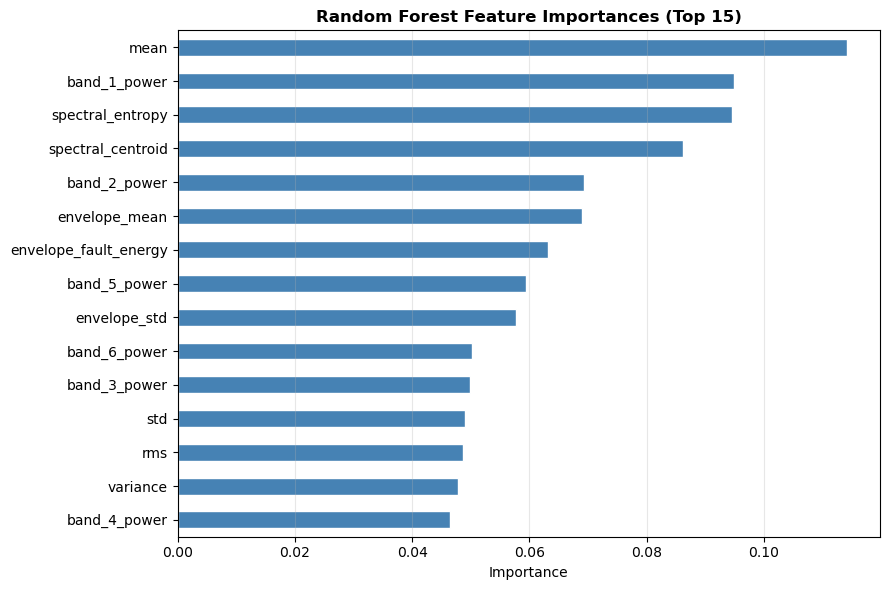

In [34]:
# ════════════════════════════════════════════════════════════════════════════════
# VISUALISE FEATURE IMPORTANCE
# ════════════════════════════════════════════════════════════════════════════════

pipeline.fit(X_selected, y)
importances = pipeline.named_steps['clf'].feature_importances_
imp_ser     = pd.Series(importances, index=top_features).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
imp_ser.plot(kind='barh', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Random Forest Feature Importances (Top 15)', fontweight='bold')
ax.set_xlabel('Importance')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show() 

In [35]:
# ════════════════════════════════════════════════════════════════════════════════
# STEP 1: Investigate why 'mean' dominates
# ════════════════════════════════════════════════════════════════════════════════

print("── Mean value per fault class ──────────────────────────────────────────")
print(feature_df.groupby('label')['mean'].describe().round(6).to_string())

print("\n── Are signals zero-centred? ────────────────────────────────────────────")
print(feature_df.groupby('label')['mean'].agg(['mean','std']).round(6).to_string())

── Mean value per fault class ──────────────────────────────────────────
                        count      mean       std       min       25%       50%       75%       max
label                                                                                              
healthy                1873.0 -0.015567  0.003595 -0.026918 -0.018087 -0.015432 -0.012726 -0.008442
inner_race_artificial  3495.0  0.017708  0.026658 -0.020898 -0.010424  0.039482  0.041947  0.047520
outer_race_artificial  3831.0  0.009752  0.027231 -0.021888 -0.013489 -0.010464  0.041300  0.048616
outer_race_real         940.0  0.003025  0.026941 -0.023103 -0.016664 -0.014818  0.039937  0.043280

── Are signals zero-centred? ────────────────────────────────────────────
                           mean       std
label                                    
healthy               -0.015567  0.003595
inner_race_artificial  0.017708  0.026658
outer_race_artificial  0.009752  0.027231
outer_race_real        0.003025  0.026941


In [36]:
# ════════════════════════════════════════════════════════════════════════════════
# STEP 2: Remove DC offset from all signals (best practice for vibration data)
# and re-check — add this inside extract_all_features
# ════════════════════════════════════════════════════════════════════════════════

def extract_all_features(sig, fs):
    # Always remove DC offset before feature extraction
    sig = sig - np.mean(sig)
    feats = {}
    feats.update(time_domain_features(sig))
    feats.update(frequency_domain_features(sig, fs))
    feats.update(envelope_features(sig, fs))
    return feats

In [37]:
# ════════════════════════════════════════════════════════════════════════════════
# STEP 3: Re-run the full pipeline with DC removal + drop 'mean' as a feature
# (mean of a zero-centred signal is uninformative noise)
# ════════════════════════════════════════════════════════════════════════════════

# Rebuild feature matrix with DC-corrected signals
feature_df = process_dataset(inventory)

# Drop 'mean' — after DC removal it carries no information
META_COLS  = ['label', 'bearing_id', 'filepath', 'segment_id', 'mean']
feat_cols  = [c for c in feature_df.columns if c not in META_COLS]

le = LabelEncoder()
y  = le.fit_transform(feature_df['label'])
X  = feature_df[feat_cols].fillna(0).values.astype(np.float32)

print(f"X shape  : {X.shape}")
print(f"Classes  : {dict(enumerate(le.classes_))}")

# Re-rank features
mi     = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_ser = pd.Series(mi, index=feat_cols).sort_values(ascending=False)

print("\nTop 15 features after DC removal:")
print(mi_ser.head(15).to_string())

top_features = mi_ser.head(15).index.tolist()
X_selected   = feature_df[top_features].fillna(0).values.astype(np.float32)

Extracting features:  39%|███▉      | 993/2560 [01:31<04:02,  6.46it/s]

  [WARN] Load failed: C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Unhealthy Data\KA08\N15_M01_F10_KA08_2.mat — Expecting matrix here


Extracting features: 100%|██████████| 2560/2560 [03:38<00:00, 11.72it/s]



Feature matrix shape : (10139, 31)
Segments per class   :
label
outer_race_artificial    3831
inner_race_artificial    3495
healthy                  1873
outer_race_real           940
X shape  : (10139, 26)
Classes  : {0: 'healthy', 1: 'inner_race_artificial', 2: 'outer_race_artificial', 3: 'outer_race_real'}

Top 15 features after DC removal:
envelope_std             0.559304
std                      0.506370
variance                 0.506333
rms                      0.506324
envelope_fault_energy    0.489656
envelope_mean            0.473511
band_1_power             0.458362
spectral_centroid        0.344904
band_5_power             0.338837
band_6_power             0.329875
band_2_power             0.304601
band_4_power             0.298549
band_3_power             0.277436
peak_to_peak             0.270085
peak                     0.247623


In [41]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 1: Diagnose — why is 'mean' dominating?
# ════════════════════════════════════════════════════════════════════════════════

print("── Mean value statistics per fault class ───────────────────────────────")
print(feature_df.groupby('label')['mean'].describe().round(6).to_string())

print("\n── Are the means actually different across classes? ────────────────────")
for label in feature_df['label'].unique():
    vals = feature_df[feature_df['label'] == label]['mean']
    print(f"  {label:<25s}  mean={vals.mean():+.6f}  std={vals.std():.6f}")

── Mean value statistics per fault class ───────────────────────────────
                        count  mean  std  min  25%  50%  75%  max
label                                                            
healthy                1873.0   0.0  0.0 -0.0 -0.0  0.0  0.0  0.0
inner_race_artificial  3495.0   0.0  0.0 -0.0 -0.0  0.0  0.0  0.0
outer_race_artificial  3831.0   0.0  0.0 -0.0 -0.0  0.0  0.0  0.0
outer_race_real         940.0   0.0  0.0 -0.0 -0.0  0.0  0.0  0.0

── Are the means actually different across classes? ────────────────────
  healthy                    mean=+0.000000  std=0.000000
  outer_race_artificial      mean=+0.000000  std=0.000000
  outer_race_real            mean=+0.000000  std=0.000000
  inner_race_artificial      mean=+0.000000  std=0.000000


In [42]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 2: Fix — DC removal inside feature extraction + drop 'mean' as feature
# Re-define extract_all_features and re-run process_dataset
# ════════════════════════════════════════════════════════════════════════════════

def extract_all_features(sig, fs):
    # Remove DC offset — vibration signals should be zero-mean
    # Without this, sensor bias differences between bearings corrupt 'mean'
    sig = sig - np.mean(sig)

    feats = {}
    feats.update(time_domain_features(sig))
    feats.update(frequency_domain_features(sig, fs))
    feats.update(envelope_features(sig, fs))
    return feats

# Rebuild the entire feature matrix with DC-corrected signals
print("Rebuilding feature matrix with DC removal...")
feature_df = process_dataset(inventory)

print(f"\n── Mean values after DC removal (should all be ~0) ─────────────────────")
for label in feature_df['label'].unique():
    vals = feature_df[feature_df['label'] == label]['mean']
    print(f"  {label:<25s}  mean={vals.mean():+.8f}  std={vals.std():.8f}")

Rebuilding feature matrix with DC removal...


Extracting features:  39%|███▉      | 993/2560 [02:08<03:29,  7.49it/s]

  [WARN] Load failed: C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Unhealthy Data\KA08\N15_M01_F10_KA08_2.mat — Expecting matrix here


Extracting features: 100%|██████████| 2560/2560 [03:56<00:00, 10.83it/s]



Feature matrix shape : (10139, 31)
Segments per class   :
label
outer_race_artificial    3831
inner_race_artificial    3495
healthy                  1873
outer_race_real           940

── Mean values after DC removal (should all be ~0) ─────────────────────
  healthy                    mean=+0.00000000  std=0.00000000
  outer_race_artificial      mean=+0.00000000  std=0.00000000
  outer_race_real            mean=+0.00000000  std=0.00000000
  inner_race_artificial      mean=+0.00000000  std=0.00000000


Feature matrix : 10139 segments × 26 features
Classes        : {0: 'healthy', 1: 'inner_race_artificial', 2: 'outer_race_artificial', 3: 'outer_race_real'}

── Top 15 features after DC removal ────────────────────────────────────
envelope_std             0.559304
std                      0.506370
variance                 0.506333
rms                      0.506324
envelope_fault_energy    0.489656
envelope_mean            0.473511
band_1_power             0.458362
spectral_centroid        0.344904
band_5_power             0.338837
band_6_power             0.329875
band_2_power             0.304601
band_4_power             0.298549
band_3_power             0.277436
peak_to_peak             0.270085
peak                     0.247623

── Cross-validation accuracy (bearing-aware) ────────────────────────────
  Per fold : [0.275 0.255 0.544 0.536 0.503]
  Mean     : 0.423  ±  0.130

── Classification Report ────────────────────────────────────────────────
                       precision    

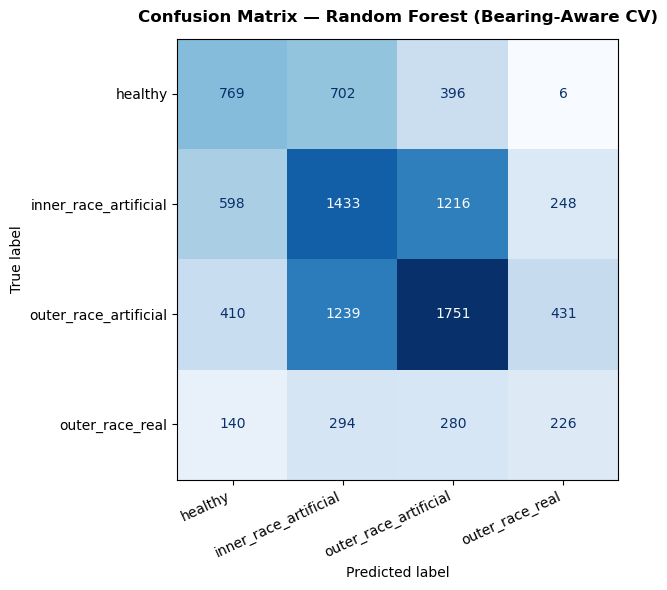

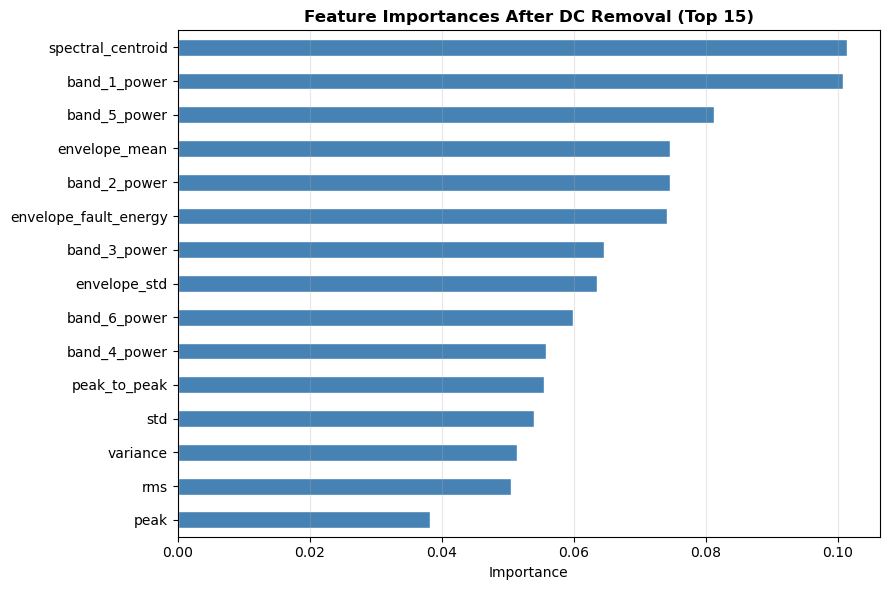


Saved to C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2:
  feature_matrix.csv
  X_selected.npy
  y_labels.npy
  label_classes.npy


In [43]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 3: Re-run feature selection + CV + plots with 'mean' excluded
# ════════════════════════════════════════════════════════════════════════════════

from sklearn.preprocessing    import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import StratifiedGroupKFold, cross_val_predict, cross_val_score
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import classification_report, ConfusionMatrixDisplay

# ── Build X, y ───────────────────────────────────────────────────────────────
# Exclude 'mean' — after DC removal it is purely noise (~0 everywhere)
META_COLS = ['label', 'bearing_id', 'filepath', 'segment_id', 'mean']
feat_cols = [c for c in feature_df.columns if c not in META_COLS]

le = LabelEncoder()
y  = le.fit_transform(feature_df['label'])
X  = feature_df[feat_cols].fillna(0).values.astype(np.float32)

print(f"Feature matrix : {X.shape[0]} segments × {X.shape[1]} features")
print(f"Classes        : {dict(enumerate(le.classes_))}\n")

# ── Mutual information ranking ────────────────────────────────────────────────
mi     = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_ser = pd.Series(mi, index=feat_cols).sort_values(ascending=False)

print("── Top 15 features after DC removal ────────────────────────────────────")
print(mi_ser.head(15).to_string())

top_features = mi_ser.head(15).index.tolist()
X_selected   = feature_df[top_features].fillna(0).values.astype(np.float32)

# ── Bearing-aware cross validation ───────────────────────────────────────────
groups = LabelEncoder().fit_transform(feature_df['bearing_id'])
cv     = StratifiedGroupKFold(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    RandomForestClassifier(n_estimators=300,
                                      class_weight='balanced',
                                      random_state=42,
                                      n_jobs=-1))
])

scores = cross_val_score(pipeline, X_selected, y,
                         cv=cv, groups=groups, scoring='accuracy')

print(f"\n── Cross-validation accuracy (bearing-aware) ────────────────────────────")
print(f"  Per fold : {np.round(scores, 3)}")
print(f"  Mean     : {scores.mean():.3f}  ±  {scores.std():.3f}")

# ── Confusion matrix ──────────────────────────────────────────────────────────
y_pred = cross_val_predict(pipeline, X_selected, y,
                            cv=cv, groups=groups)

print("\n── Classification Report ────────────────────────────────────────────────")
print(classification_report(y, y_pred, target_names=le.classes_, digits=3))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred,
    display_labels=le.classes_,
    cmap='Blues',
    ax=ax,
    colorbar=False
)
ax.set_title('Confusion Matrix — Random Forest (Bearing-Aware CV)',
             fontweight='bold', pad=12)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# ── Feature importance plot ───────────────────────────────────────────────────
pipeline.fit(X_selected, y)
imp_ser = pd.Series(
    pipeline.named_steps['clf'].feature_importances_,
    index=top_features
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
imp_ser.plot(kind='barh', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Feature Importances After DC Removal (Top 15)',
             fontweight='bold')
ax.set_xlabel('Importance')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ── Save outputs ──────────────────────────────────────────────────────────────
save_dir = r'C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2'

feature_df.to_csv(os.path.join(save_dir, 'feature_matrix.csv'), index=False)
np.save(os.path.join(save_dir, 'X_selected.npy'),    X_selected)
np.save(os.path.join(save_dir, 'y_labels.npy'),      y)
np.save(os.path.join(save_dir, 'label_classes.npy'), le.classes_)

print(f"\nSaved to {save_dir}:")
print("  feature_matrix.csv")
print("  X_selected.npy")
print("  y_labels.npy")
print("  label_classes.npy")

In [44]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 1: Diagnose class imbalance — how many files per class?
# ════════════════════════════════════════════════════════════════════════════════

print("── Files per class ─────────────────────────────────────────────────────")
print(inventory['label'].value_counts().to_string())

print("\n── Segments per class (current) ────────────────────────────────────────")
print(feature_df['label'].value_counts().to_string())

print("\n── Bearings per class ──────────────────────────────────────────────────")
print(feature_df.groupby('label')['bearing_id'].nunique().to_string())

print("\n── Segments per bearing (sample — first 10) ────────────────────────────")
print(feature_df.groupby(['label','bearing_id']).size()
      .reset_index(name='n_segments')
      .sort_values(['label','n_segments'])
      .head(20).to_string(index=False))

── Files per class ─────────────────────────────────────────────────────
label
outer_race_artificial    960
inner_race_artificial    880
healthy                  480
outer_race_real          240

── Segments per class (current) ────────────────────────────────────────
label
outer_race_artificial    3831
inner_race_artificial    3495
healthy                  1873
outer_race_real           940

── Bearings per class ──────────────────────────────────────────────────
label
healthy                   6
inner_race_artificial    11
outer_race_artificial    12
outer_race_real           3

── Segments per bearing (sample — first 10) ────────────────────────────
                label bearing_id  n_segments
              healthy       K006         303
              healthy       K001         306
              healthy       K005         311
              healthy       K003         314
              healthy       K004         319
              healthy       K002         320
inner_race_artificial   

In [46]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 2: Fix class imbalance — cap segments per CLASS not per file
# Also fix the bad file warning by adding better error handling
# ════════════════════════════════════════════════════════════════════════════════

def process_dataset_balanced(inventory_df,
                              fs_target=FS_TARGET,
                              segment_length_s=1.0,
                              segments_per_class=800):
    """
    Builds a balanced feature matrix by capping total segments per class.

    Key differences from original process_dataset:
    - segments_per_class: hard cap per label (not per file)
    - Shuffles files within each class so the cap samples broadly
      across different bearings rather than just the first few files
    - Skips corrupted files gracefully
    """
    seg_samples = int(segment_length_s * fs_target)

    # Group files by class and shuffle within each class
    classes     = inventory_df['label'].unique()
    all_rows    = []

    for cls in classes:
        cls_files  = inventory_df[inventory_df['label'] == cls].sample(
                         frac=1, random_state=42).reset_index(drop=True)
        cls_count  = 0
        print(f"\n  Processing class '{cls}' ({len(cls_files)} files)...")

        for _, row in cls_files.iterrows():
            if cls_count >= segments_per_class:
                break

            try:
                results, fault_type, bearing_id = load_bearing_file(row['filepath'])
            except Exception as e:
                continue   # silently skip bad files

            if not results:
                continue

            r      = results[0]
            sig_ds = downsample_signal(r['signal'], r['fs'], fs_target)
            n_segs = len(sig_ds) // seg_samples

            for s in range(n_segs):
                if cls_count >= segments_per_class:
                    break
                segment = sig_ds[s * seg_samples:(s + 1) * seg_samples]
                feats   = extract_all_features(segment, fs=fs_target)

                feats['label']      = fault_type
                feats['bearing_id'] = bearing_id
                feats['filepath']   = row['filepath']
                feats['segment_id'] = s
                all_rows.append(feats)
                cls_count += 1

        print(f"    → collected {cls_count} segments")

    feature_df = pd.DataFrame(all_rows)

    print(f"\n✓ Balanced feature matrix shape: {feature_df.shape}")
    print("\n── Segments per class ──────────────────────────────────────────────")
    print(feature_df['label'].value_counts().to_string())
    print("\n── Unique bearings per class ───────────────────────────────────────")
    print(feature_df.groupby('label')['bearing_id'].nunique().to_string())
    return feature_df


# outer_race_real only has ~940 segments total, so cap everything at 800
# to stay balanced while keeping as much outer_race_real as possible
feature_df_balanced = process_dataset_balanced(inventory, segments_per_class=800)


  Processing class 'healthy' (480 files)...
    → collected 800 segments

  Processing class 'outer_race_artificial' (960 files)...
    → collected 800 segments

  Processing class 'outer_race_real' (240 files)...
    → collected 800 segments

  Processing class 'inner_race_artificial' (880 files)...
    → collected 800 segments

✓ Balanced feature matrix shape: (3200, 31)

── Segments per class ──────────────────────────────────────────────
label
healthy                  800
outer_race_artificial    800
outer_race_real          800
inner_race_artificial    800

── Unique bearings per class ───────────────────────────────────────
label
healthy                   6
inner_race_artificial    11
outer_race_artificial    12
outer_race_real           3


In [50]:
# ════════════════════════════════════════════════════════════════════════════════
# Full breakdown — files, bearings, and segments per class
# ════════════════════════════════════════════════════════════════════════════════

print("── Files per class (from inventory) ────────────────────────────────────")
print(inventory['label'].value_counts().to_string())

print("\n── Unique bearing IDs per class ────────────────────────────────────────")
print(inventory.groupby('label')['bearing_id'].nunique().to_string())

print("\n── Bearing IDs per class (full list) ───────────────────────────────────")
for cls in sorted(inventory['label'].unique()):
    bearings = sorted(inventory[inventory['label'] == cls]['bearing_id'].unique())
    print(f"\n  {cls} ({len(bearings)} bearings):")
    print(f"    {bearings}")

print("\n── Files per bearing ID ────────────────────────────────────────────────")
print(inventory.groupby(['label','bearing_id']).size()
      .reset_index(name='n_files')
      .to_string(index=False))

── Files per class (from inventory) ────────────────────────────────────
label
outer_race_artificial    960
inner_race_artificial    880
healthy                  480
outer_race_real          240

── Unique bearing IDs per class ────────────────────────────────────────
label
healthy                   6
inner_race_artificial    11
outer_race_artificial    12
outer_race_real           3

── Bearing IDs per class (full list) ───────────────────────────────────

  healthy (6 bearings):
    ['K001', 'K002', 'K003', 'K004', 'K005', 'K006']

  inner_race_artificial (11 bearings):
    ['KI01', 'KI03', 'KI04', 'KI05', 'KI07', 'KI08', 'KI14', 'KI16', 'KI17', 'KI18', 'KI21']

  outer_race_artificial (12 bearings):
    ['KA01', 'KA03', 'KA04', 'KA05', 'KA06', 'KA07', 'KA08', 'KA09', 'KA15', 'KA16', 'KA22', 'KA30']

  outer_race_real (3 bearings):
    ['KB23', 'KB24', 'KB27']

── Files per bearing ID ────────────────────────────────────────────────
                label bearing_id  n_files
         

In [51]:
# ════════════════════════════════════════════════════════════════════════════════
# Exact sample count — total raw signal samples across all files
# ════════════════════════════════════════════════════════════════════════════════

print("── Counting raw samples across all files ───────────────────────────────")
summary = []

for _, row in tqdm(inventory.iterrows(), total=len(inventory), desc='Counting'):
    try:
        results, fault_type, bearing_id = load_bearing_file(row['filepath'])
        if results:
            n_samples = len(results[0]['signal'])
            fs        = results[0]['fs']
            summary.append({
                'label':      fault_type,
                'bearing_id': bearing_id,
                'n_samples':  n_samples,
                'fs':         fs,
                'duration_s': n_samples / fs,
            })
    except Exception:
        continue

summary_df = pd.DataFrame(summary)

print("\n── Per class: total raw samples + total duration ───────────────────────")
agg = summary_df.groupby('label').agg(
    n_files      = ('n_samples', 'count'),
    total_samples= ('n_samples', 'sum'),
    mean_samples = ('n_samples', 'mean'),
    total_hours  = ('duration_s', lambda x: x.sum() / 3600)
).reset_index()
print(agg.to_string(index=False))

print("\n── Grand total ─────────────────────────────────────────────────────────")
print(f"  Total files   : {len(summary_df)}")
print(f"  Total samples : {summary_df['n_samples'].sum():,}")
print(f"  Total duration: {summary_df['duration_s'].sum()/3600:.2f} hours")

print("\n── Per class: segments available at 1s windows @ 16kHz (16000 samples) ─")
seg_size = 16000
for _, r in agg.iterrows():
    max_segs = int(r['total_samples'] / seg_size)
    print(f"  {r['label']:<25s}  total_samples={int(r['total_samples']):>10,}  "
          f"max_1s_segments={max_segs:>6,}")

── Counting raw samples across all files ───────────────────────────────


Counting: 100%|██████████| 2560/2560 [00:34<00:00, 73.66it/s]


── Per class: total raw samples + total duration ───────────────────────
                label  n_files  total_samples  mean_samples  total_hours
              healthy      480      123152088 256566.850000     0.539884
inner_race_artificial      880      226031195 256853.630682     0.992093
outer_race_artificial      959      246197042 256722.671533     1.081421
      outer_race_real      240       61645382 256855.758333     0.270252

── Grand total ─────────────────────────────────────────────────────────
  Total files   : 2559
  Total samples : 657,025,707
  Total duration: 2.88 hours

── Per class: segments available at 1s windows @ 16kHz (16000 samples) ─
  healthy                    total_samples=123,152,088  max_1s_segments= 7,697
  inner_race_artificial      total_samples=226,031,195  max_1s_segments=14,126
  outer_race_artificial      total_samples=246,197,042  max_1s_segments=15,387
  outer_race_real            total_samples=61,645,382  max_1s_segments= 3,852


In [29]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 0: Re-run all dependencies after kernel restart
# ════════════════════════════════════════════════════════════════════════════════

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import h5py
from math import gcd
from scipy.stats import kurtosis, skew
from tqdm import tqdm
import torch

warnings.filterwarnings('ignore')


In [5]:
# ── All functions needed (consolidated) ───────────────────────────────────────

def get_label_from_filepath(filepath):
    norm   = filepath.replace('\\', '/')
    parts  = norm.split('/')
    bearing_folder = parts[-2].upper().strip()
    top_folder     = parts[-3].lower().strip()

    if 'healthy' in top_folder and 'unhealthy' not in top_folder:
        fault_type = 'healthy'
    elif bearing_folder.startswith('KIB'):
        fault_type = 'inner_race_real'
    elif bearing_folder.startswith('KI'):
        fault_type = 'inner_race_artificial'
    elif bearing_folder.startswith('KA'):
        fault_type = 'outer_race_artificial'
    elif bearing_folder.startswith('KB'):
        fault_type = 'outer_race_real'
    else:
        fault_type = 'unknown'
    return fault_type, bearing_folder


def load_mat_file(filepath):
    try:
        data = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)
        return data, 'scipy'
    except NotImplementedError:
        data = h5py.File(filepath, 'r')
        return data, 'h5py'


def extract_vibration_scipy(data):
    results  = []
    run_keys = [k for k in data.keys() if not k.startswith('_')]
    for run_key in run_keys:
        obj = data[run_key]
        try:
            time_vec  = obj.X[1].Data.ravel().astype(np.float64)
            fs_actual = round(1.0 / float(np.median(np.diff(time_vec))))
        except Exception:
            fs_actual = FS_ORIGINAL
        try:
            sig = obj.Y[6].Data.ravel().astype(np.float64)
            results.append({'signal': sig, 'fs': fs_actual, 'run_key': run_key})
        except Exception:
            continue
    return results


def extract_vibration_h5py(filepath):
    results = []
    with h5py.File(filepath, 'r') as f:
        def _grab(name, obj):
            if isinstance(obj, h5py.Dataset) and 'vibration' in name.lower():
                arr = np.array(obj).ravel().astype(np.float64)
                if len(arr) > 1000:
                    results.append({'signal': arr, 'fs': FS_ORIGINAL, 'run_key': name})
        f.visititems(_grab)
    return results


def load_bearing_file(filepath):
    fault_type, bearing_id = get_label_from_filepath(filepath)
    data, loader = load_mat_file(filepath)
    if loader == 'scipy':
        results = extract_vibration_scipy(data)
    else:
        data.close()
        results = extract_vibration_h5py(filepath)
    return results, fault_type, bearing_id


def downsample_signal(signal, fs_orig, fs_target=FS_TARGET):
    up   = int(fs_target)
    down = int(fs_orig)
    common = gcd(up, down)
    return scipy.signal.resample_poly(signal, up // common, down // common)


def build_file_inventory(root_dir):
    root_dir = os.path.abspath(root_dir)
    records  = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith('.mat'):
                fpath = os.path.join(dirpath, fname)
                fault_type, bearing_id = get_label_from_filepath(fpath)
                records.append({'filepath': fpath, 'filename': fname,
                                'label': fault_type, 'bearing_id': bearing_id})
    df = pd.DataFrame(records)
    print(f"✓ Found {len(df)} .mat files")
    print(df['label'].value_counts().to_string())
    return df


# ── Rebuild inventory ─────────────────────────────────────────────────────────
inventory = build_file_inventory(DATA_ROOT)
print(f"\nInventory ready: {len(inventory)} files")

✓ Found 2560 .mat files
label
outer_race_artificial    960
inner_race_artificial    880
healthy                  480
outer_race_real          240

Inventory ready: 2560 files


In [6]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 1: Build the raw sequence dataset
# 0.5s windows @ 16kHz = 8,000 samples per segment
# ════════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

DEVICE      = torch.device('cuda:0')
SEG_SAMPLES = 8_000       # 0.5s @ 16kHz
FS_TARGET   = 16_000
SEGMENTS_PER_CLASS = 3800

print(f"Using device: {DEVICE} ({torch.cuda.get_device_name(0)})")
print(f"Segment length: {SEG_SAMPLES} samples ({SEG_SAMPLES/FS_TARGET:.2f}s)")


def build_sequence_dataset(inventory_df,
                            fs_target=FS_TARGET,
                            seg_samples=SEG_SAMPLES,
                            segments_per_class=SEGMENTS_PER_CLASS):
    """
    Loads raw signals, downsamples, slices into windows.
    Returns X (n_segments, seg_samples) and y (n_segments,) as numpy arrays.
    """
    classes  = inventory_df['label'].unique()
    all_X, all_y, all_groups = [], [], []

    le = LabelEncoder()
    le.fit(sorted(classes))

    for cls in sorted(classes):
        cls_files = inventory_df[inventory_df['label'] == cls].sample(
                        frac=1, random_state=42).reset_index(drop=True)
        cls_count = 0
        print(f"\n  [{cls}] collecting {segments_per_class} segments...")

        for _, row in cls_files.iterrows():
            if cls_count >= segments_per_class:
                break
            try:
                results, fault_type, bearing_id = load_bearing_file(row['filepath'])
            except Exception:
                continue
            if not results:
                continue

            r      = results[0]
            sig_ds = downsample_signal(r['signal'], r['fs'], fs_target)
            sig_ds = sig_ds - np.mean(sig_ds)   # DC removal

            n_segs = len(sig_ds) // seg_samples
            for s in range(n_segs):
                if cls_count >= segments_per_class:
                    break
                seg = sig_ds[s * seg_samples:(s + 1) * seg_samples]

                # Normalise each window to zero mean, unit variance
                seg = (seg - seg.mean()) / (seg.std() + 1e-8)

                all_X.append(seg.astype(np.float32))
                all_y.append(le.transform([cls])[0])
                all_groups.append(bearing_id)
                cls_count += 1

        print(f"    → collected {cls_count} segments")

    X      = np.array(all_X, dtype=np.float32)   # (N, 8000)
    y      = np.array(all_y, dtype=np.int64)
    groups = np.array(all_groups)

    print(f"\n✓ Dataset shape : {X.shape}")
    print(f"  Classes       : {dict(enumerate(le.classes_))}")
    print(f"  Label counts  : {np.bincount(y)}")
    return X, y, groups, le


X_seq, y_seq, groups_seq, label_encoder = build_sequence_dataset(inventory)

Using device: cuda:0 (NVIDIA GeForce RTX 4060 Laptop GPU)
Segment length: 8000 samples (0.50s)

  [healthy] collecting 3800 segments...
    → collected 3793 segments

  [inner_race_artificial] collecting 3800 segments...
    → collected 3800 segments

  [outer_race_artificial] collecting 3800 segments...
    → collected 3800 segments

  [outer_race_real] collecting 3800 segments...
    → collected 1900 segments

✓ Dataset shape : (13293, 8000)
  Classes       : {0: np.str_('healthy'), 1: np.str_('inner_race_artificial'), 2: np.str_('outer_race_artificial'), 3: np.str_('outer_race_real')}
  Label counts  : [3793 3800 3800 1900]


In [7]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 2: Train/validation/test split — bearing-aware
# No segments from the same bearing appear in both train and test
# ════════════════════════════════════════════════════════════════════════════════

from sklearn.model_selection import GroupShuffleSplit

# First split: 80% train+val, 20% test (by bearing group)
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_val_idx, test_idx = next(gss.split(X_seq, y_seq, groups=groups_seq))

X_trainval = X_seq[train_val_idx]
y_trainval = y_seq[train_val_idx]
g_trainval = groups_seq[train_val_idx]

X_test = X_seq[test_idx]
y_test = y_seq[test_idx]

# Second split: 75/25 of trainval → 60% train, 20% val overall
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss2.split(X_trainval, y_trainval, groups=g_trainval))

X_train = X_trainval[train_idx]
y_train = y_trainval[train_idx]
X_val   = X_trainval[val_idx]
y_val   = y_trainval[val_idx]

print(f"Train : {X_train.shape}  labels: {np.bincount(y_train)}")
print(f"Val   : {X_val.shape}    labels: {np.bincount(y_val)}")
print(f"Test  : {X_test.shape}   labels: {np.bincount(y_test)}")

Train : (8288, 8000)  labels: [3167 2551 1310 1260]
Val   : (2859, 8000)    labels: [ 626  321 1272  640]
Test  : (2146, 8000)   labels: [   0  928 1218]


In [8]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 3: PyTorch Dataset + DataLoader
# ════════════════════════════════════════════════════════════════════════════════

class BearingDataset(Dataset):
    def __init__(self, X, y):
        # Shape: (N, 1, seq_len) — 1 channel for Conv1d
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Weighted sampler to handle any residual class imbalance
def make_weighted_sampler(y):
    counts  = np.bincount(y)
    weights = 1.0 / counts[y]
    return WeightedRandomSampler(
        weights=torch.tensor(weights, dtype=torch.float32),
        num_samples=len(y),
        replacement=True
    )

BATCH_SIZE = 64

train_ds = BearingDataset(X_train, y_train)
val_ds   = BearingDataset(X_val,   y_val)
test_ds  = BearingDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=make_weighted_sampler(y_train),
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")

Train batches : 130
Val batches   : 45
Test batches  : 34


In [11]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 4: CNN + LSTM Hybrid Model
#
# Architecture:
#   Input  (batch, 1, 8000)
#     ↓ CNN blocks — extract local temporal features → reduce sequence length
#   (batch, 128, 125)       ← 8000 → 125 via stride/pooling
#     ↓ LSTM layers — learn long-range dependencies across CNN features
#   (batch, 128)             ← last hidden state
#     ↓ Classifier head
#   (batch, 4)               ← 4 fault classes
# ════════════════════════════════════════════════════════════════════════════════

class CNNLSTMClassifier(nn.Module):
    def __init__(self, seq_len=8000, n_classes=4,
                 cnn_channels=(32, 64, 128),
                 lstm_hidden=128, lstm_layers=2,
                 dropout=0.3):
        super().__init__()

        # ── CNN feature extractor ─────────────────────────────────────────────
        # Each block: Conv1d → BatchNorm → ReLU → MaxPool(2)
        # 3 blocks with pool(2) each → seq_len reduced by 8×
        # Plus initial large kernel to capture low-freq patterns

        self.cnn = nn.Sequential(
            # Block 0 — wide kernel, captures macro patterns
            nn.Conv1d(1, cnn_channels[0],
                      kernel_size=64, stride=4, padding=30),
            nn.BatchNorm1d(cnn_channels[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),            # /2

            # Block 1
            nn.Conv1d(cnn_channels[0], cnn_channels[1],
                      kernel_size=16, stride=1, padding=8),
            nn.BatchNorm1d(cnn_channels[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),            # /2

            # Block 2
            nn.Conv1d(cnn_channels[1], cnn_channels[2],
                      kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(cnn_channels[2]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),            # /2
        )

        # Compute CNN output length dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, seq_len)
            cnn_out = self.cnn(dummy)
            self.cnn_out_len = cnn_out.shape[2]
            self.cnn_out_ch  = cnn_out.shape[1]

        print(f"  CNN output shape : (batch, {self.cnn_out_ch}, {self.cnn_out_len})")

        # ── LSTM ──────────────────────────────────────────────────────────────
        # Input to LSTM: (batch, cnn_out_len, cnn_out_ch)
        # i.e. cnn_out_len timesteps, each with cnn_out_ch features
        self.lstm = nn.LSTM(
            input_size=self.cnn_out_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True           # bidirectional doubles hidden size
        )

        lstm_out_size = lstm_hidden * 2  # bidirectional

        # ── Classifier head ───────────────────────────────────────────────────
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_out_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        # x: (batch, 1, seq_len)
        cnn_out = self.cnn(x)                          # (batch, ch, reduced_len)
        cnn_out = cnn_out.permute(0, 2, 1)             # (batch, reduced_len, ch)
        lstm_out, _ = self.lstm(cnn_out)               # (batch, reduced_len, hidden*2)
        last_hidden  = lstm_out[:, -1, :]              # take last timestep
        return self.classifier(last_hidden)            # (batch, n_classes)


# Instantiate and move to GPU
model = CNNLSTMClassifier(
    seq_len=SEG_SAMPLES,
    n_classes=4,
    cnn_channels=(32, 64, 128),
    lstm_hidden=128,
    lstm_layers=2,
    dropout=0.3
).to(DEVICE)

# Print parameter count
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n  Total trainable parameters: {total_params:,}")
print(f"  Model on device: {next(model.parameters()).device}")

  CNN output shape : (batch, 128, 250)

  Total trainable parameters: 777,188
  Model on device: cuda:0


In [14]:
# ════════════════════════════════════════════════════════════════════════════════
# FIX: Redefine DataLoaders with num_workers=0 (required on Windows + Jupyter)
# ════════════════════════════════════════════════════════════════════════════════

BATCH_SIZE = 64

train_ds = BearingDataset(X_train, y_train)
val_ds   = BearingDataset(X_val,   y_val)
test_ds  = BearingDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=make_weighted_sampler(y_train),
                          num_workers=0,        # ← fixed: was 4
                          pin_memory=True)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,        # ← fixed: was 4
                          pin_memory=True)

test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,        # ← fixed: was 4
                          pin_memory=True)

print(f"✓ DataLoaders ready")
print(f"  Train batches : {len(train_loader)}")
print(f"  Val batches   : {len(val_loader)}")
print(f"  Test batches  : {len(test_loader)}")

✓ DataLoaders ready
  Train batches : 130
  Val batches   : 45
  Test batches  : 34


In [15]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 5: Training loop with early stopping + learning rate scheduler
# ════════════════════════════════════════════════════════════════════════════════

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Class weights to handle any remaining imbalance
class_counts = np.bincount(y_train)
class_weights = torch.tensor(
    1.0 / class_counts, dtype=torch.float32).to(DEVICE)
class_weights = class_weights / class_weights.sum() * len(class_counts)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                               patience=5, verbose=True)

N_EPOCHS       = 60
EARLY_STOP_PAT = 10   # stop if val loss doesn't improve for 10 epochs

best_val_loss  = float('inf')
best_model_wts = None
patience_count = 0
history        = {'train_loss': [], 'val_loss': [],
                  'train_acc':  [], 'val_acc':  []}

print("Starting training...\n")
print(f"{'Epoch':>5}  {'Train Loss':>10}  {'Train Acc':>9}  "
      f"{'Val Loss':>8}  {'Val Acc':>7}  {'LR':>8}")
print("─" * 60)

for epoch in range(1, N_EPOCHS + 1):

    # ── Training ──────────────────────────────────────────────────────────────
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE, non_blocking=True)
        y_batch = y_batch.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss    += loss.item() * len(y_batch)
        preds          = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total   += len(y_batch)

    train_loss /= train_total
    train_acc   = train_correct / train_total

    # ── Validation ────────────────────────────────────────────────────────────
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE, non_blocking=True)
            y_batch = y_batch.to(DEVICE, non_blocking=True)
            logits  = model(X_batch)
            loss    = criterion(logits, y_batch)

            val_loss    += loss.item() * len(y_batch)
            preds        = logits.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total   += len(y_batch)

    val_loss /= val_total
    val_acc   = val_correct / val_total

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"{epoch:>5}  {train_loss:>10.4f}  {train_acc:>9.3f}  "
          f"{val_loss:>8.4f}  {val_acc:>7.3f}  {current_lr:>8.6f}")

    # ── Early stopping ────────────────────────────────────────────────────────
    if val_loss < best_val_loss:
        best_val_loss  = val_loss
        best_model_wts = {k: v.cpu().clone()
                          for k, v in model.state_dict().items()}
        patience_count = 0
    else:
        patience_count += 1
        if patience_count >= EARLY_STOP_PAT:
            print(f"\n  Early stopping at epoch {epoch} "
                  f"(no improvement for {EARLY_STOP_PAT} epochs)")
            break

# Restore best weights
model.load_state_dict(best_model_wts)
print(f"\n✓ Best val loss: {best_val_loss:.4f}")

Starting training...

Epoch  Train Loss  Train Acc  Val Loss  Val Acc        LR
────────────────────────────────────────────────────────────
    1      0.5435      0.681    3.7365    0.075  0.001000
    2      0.2247      0.889    2.9542    0.374  0.001000
    3      0.1268      0.947    4.5284    0.216  0.001000
    4      0.0831      0.969    3.3264    0.560  0.001000
    5      0.0698      0.973    3.6948    0.425  0.001000
    6      0.0449      0.983    6.0851    0.323  0.001000
    7      0.0463      0.984    3.6115    0.411  0.001000
    8      0.0301      0.989    3.3256    0.570  0.000500
    9      0.0191      0.993    3.8463    0.519  0.000500
   10      0.0142      0.994    5.2613    0.348  0.000500
   11      0.0137      0.994    3.3070    0.580  0.000500
   12      0.0125      0.996    4.5844    0.460  0.000500

  Early stopping at epoch 12 (no improvement for 10 epochs)

✓ Best val loss: 2.9542


── Test Set Classification Report ──────────────────────────────────────
                       precision    recall  f1-score   support

              healthy      0.000     0.000     0.000         0
inner_race_artificial      0.470     0.362     0.409       928
outer_race_artificial      0.575     0.233     0.332      1218
      outer_race_real      0.000     0.000     0.000         0

             accuracy                          0.289      2146
            macro avg      0.261     0.149     0.185      2146
         weighted avg      0.530     0.289     0.365      2146



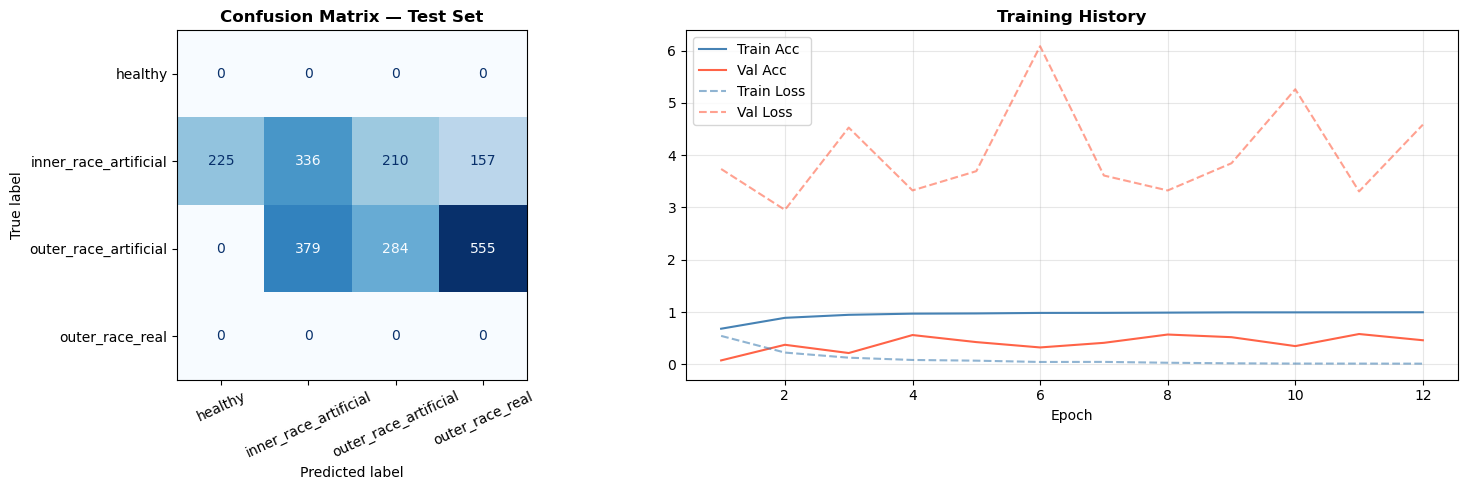

In [16]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 6: Evaluate on held-out test set + plots
# ════════════════════════════════════════════════════════════════════════════════

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(DEVICE))
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_true  = np.array(all_true)

print("── Test Set Classification Report ──────────────────────────────────────")
print(classification_report(all_true, all_preds,
                             target_names=label_encoder.classes_, digits=3))

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ConfusionMatrixDisplay.from_predictions(
    all_true, all_preds,
    display_labels=label_encoder.classes_,
    cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix — Test Set', fontweight='bold')
axes[0].tick_params(axis='x', rotation=25)

# Training curves
epochs_ran = range(1, len(history['train_loss']) + 1)
axes[1].plot(epochs_ran, history['train_acc'], label='Train Acc', color='steelblue')
axes[1].plot(epochs_ran, history['val_acc'],   label='Val Acc',   color='tomato')
axes[1].plot(epochs_ran, history['train_loss'], label='Train Loss',
             color='steelblue', linestyle='--', alpha=0.6)
axes[1].plot(epochs_ran, history['val_loss'],   label='Val Loss',
             color='tomato',    linestyle='--', alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Training History', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 7: Save the model
# ════════════════════════════════════════════════════════════════════════════════

save_dir = r'C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2'

torch.save({
    'model_state_dict': model.state_dict(),
    'label_classes':    label_encoder.classes_,
    'seg_samples':      SEG_SAMPLES,
    'fs_target':        FS_TARGET,
    'history':          history,
}, os.path.join(save_dir, 'cnn_lstm_model.pth'))

print("✓ Model saved to cnn_lstm_model.pth")

# To reload later:
# checkpoint = torch.load('cnn_lstm_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

✓ Model saved to cnn_lstm_model.pth


In [18]:
# ════════════════════════════════════════════════════════════════════════════════
# FIX 1: Stratified bearing-aware split that guarantees all classes in test
# ════════════════════════════════════════════════════════════════════════════════

from collections import defaultdict

def bearing_aware_split(X, y, groups, test_size=0.20, val_size=0.20, random_state=42):
    """
    Splits by bearing ID while guaranteeing every class appears in
    train, val, AND test. Works even with only 3 bearings per class.

    Strategy: for each class, sort its bearings and assign:
      - last 1 bearing  → test
      - second-last 1   → val
      - rest            → train
    """
    np.random.seed(random_state)

    train_idx, val_idx, test_idx = [], [], []

    # Get unique bearings per class
    for cls in np.unique(y):
        cls_mask    = (y == cls)
        cls_indices = np.where(cls_mask)[0]
        cls_groups  = groups[cls_mask]

        unique_bearings = sorted(set(cls_groups))
        n = len(unique_bearings)

        print(f"  Class {cls:>2} ({label_encoder.classes_[cls]:<25s}): "
              f"{n} bearings → ", end='')

        if n < 3:
            # Too few bearings — use last for test, rest for train (no val from this class)
            test_bearing  = [unique_bearings[-1]]
            val_bearing   = [unique_bearings[-2]] if n >= 2 else []
            train_bearing = unique_bearings[:-2] if n >= 2 else unique_bearings[:-1]
        else:
            test_bearing  = [unique_bearings[-1]]
            val_bearing   = [unique_bearings[-2]]
            train_bearing = unique_bearings[:-2]

        print(f"train={len(train_bearing)} val={len(val_bearing)} test={len(test_bearing)}")

        for i in cls_indices:
            b = groups[i]
            if b in test_bearing:
                test_idx.append(i)
            elif b in val_bearing:
                val_idx.append(i)
            else:
                train_idx.append(i)

    return (np.array(train_idx), np.array(val_idx), np.array(test_idx))


print("── Bearing split ────────────────────────────────────────────────────────")
train_idx, val_idx, test_idx = bearing_aware_split(
    X_seq, y_seq, groups_seq)

X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val,   y_val   = X_seq[val_idx],   y_seq[val_idx]
X_test,  y_test  = X_seq[test_idx],  y_seq[test_idx]

print(f"\n  Train : {X_train.shape}  labels: {np.bincount(y_train)}")
print(f"  Val   : {X_val.shape}    labels: {np.bincount(y_val)}")
print(f"  Test  : {X_test.shape}   labels: {np.bincount(y_test)}")

── Bearing split ────────────────────────────────────────────────────────
  Class  0 (healthy                  ): 6 bearings → train=4 val=1 test=1
  Class  1 (inner_race_artificial    ): 11 bearings → train=9 val=1 test=1
  Class  2 (outer_race_artificial    ): 12 bearings → train=10 val=1 test=1
  Class  3 (outer_race_real          ): 3 bearings → train=1 val=1 test=1

  Train : (9539, 8000)  labels: [2539 3144 3216  640]
  Val   : (1795, 8000)    labels: [631 288 256 620]
  Test  : (1959, 8000)   labels: [623 368 328 640]


In [19]:
# ════════════════════════════════════════════════════════════════════════════════
# FIX 2: Rebuilt model with strong regularisation to fix overfitting
# Key changes:
#   - Higher dropout (0.5)
#   - Smaller LSTM (64 hidden, 1 layer) — less capacity to memorise
#   - L2 weight decay increased (1e-3)
#   - Gradient clipping kept
#   - Label smoothing in loss function
# ════════════════════════════════════════════════════════════════════════════════

class CNNLSTMClassifier(nn.Module):
    def __init__(self, seq_len=8000, n_classes=4,
                 cnn_channels=(32, 64, 128),
                 lstm_hidden=64, lstm_layers=1,
                 dropout=0.5):
        super().__init__()

        self.cnn = nn.Sequential(
            # Block 0 — wide kernel
            nn.Conv1d(1, cnn_channels[0], kernel_size=64, stride=4, padding=30),
            nn.BatchNorm1d(cnn_channels[0]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            # Block 1
            nn.Conv1d(cnn_channels[0], cnn_channels[1], kernel_size=16,
                      stride=1, padding=8),
            nn.BatchNorm1d(cnn_channels[1]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv1d(cnn_channels[1], cnn_channels[2], kernel_size=8,
                      stride=1, padding=4),
            nn.BatchNorm1d(cnn_channels[2]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
        )

        with torch.no_grad():
            dummy       = torch.zeros(1, 1, seq_len)
            cnn_out     = self.cnn(dummy)
            self.cnn_out_len = cnn_out.shape[2]
            self.cnn_out_ch  = cnn_out.shape[1]

        print(f"  CNN output: (batch, {self.cnn_out_ch}, {self.cnn_out_len})")

        # Smaller LSTM — 1 layer, not bidirectional to reduce overfitting
        self.lstm = nn.LSTM(
            input_size=self.cnn_out_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 32),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        cnn_out      = self.cnn(x)
        cnn_out      = cnn_out.permute(0, 2, 1)
        lstm_out, _  = self.lstm(cnn_out)
        last_hidden  = lstm_out[:, -1, :]
        return self.classifier(last_hidden)


model = CNNLSTMClassifier(
    seq_len=SEG_SAMPLES,
    n_classes=4,
    cnn_channels=(32, 64, 128),
    lstm_hidden=64,
    lstm_layers=1,
    dropout=0.5
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Trainable parameters: {total_params:,}")

  CNN output: (batch, 128, 250)
  Trainable parameters: 152,900


In [20]:
# ════════════════════════════════════════════════════════════════════════════════
# FIX 3: Rebuild dataloaders + retrain with better settings
# ════════════════════════════════════════════════════════════════════════════════

BATCH_SIZE = 64

train_ds = BearingDataset(X_train, y_train)
val_ds   = BearingDataset(X_val,   y_val)
test_ds  = BearingDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=make_weighted_sampler(y_train),
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=0, pin_memory=True)

# Loss with label smoothing — reduces overconfidence
class_counts  = np.bincount(y_train)
class_weights = torch.tensor(1.0 / class_counts,
                              dtype=torch.float32).to(DEVICE)
class_weights = class_weights / class_weights.sum() * 4

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                               patience=7, verbose=True)

N_EPOCHS       = 80
EARLY_STOP_PAT = 15
best_val_loss  = float('inf')
best_model_wts = None
patience_count = 0
history        = {'train_loss': [], 'val_loss': [],
                  'train_acc':  [], 'val_acc':  []}

print("Starting training...\n")
print(f"{'Epoch':>5}  {'Train Loss':>10}  {'Train Acc':>9}  "
      f"{'Val Loss':>8}  {'Val Acc':>7}  {'LR':>8}")
print("─" * 60)

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE, non_blocking=True)
        y_batch = y_batch.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss    += loss.item() * len(y_batch)
        train_correct += (logits.argmax(1) == y_batch).sum().item()
        train_total   += len(y_batch)

    train_loss /= train_total
    train_acc   = train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(DEVICE, non_blocking=True)
            y_batch = y_batch.to(DEVICE, non_blocking=True)
            logits  = model(X_batch)
            loss    = criterion(logits, y_batch)
            val_loss    += loss.item() * len(y_batch)
            val_correct += (logits.argmax(1) == y_batch).sum().item()
            val_total   += len(y_batch)

    val_loss /= val_total
    val_acc   = val_correct / val_total

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"{epoch:>5}  {train_loss:>10.4f}  {train_acc:>9.3f}  "
          f"{val_loss:>8.4f}  {val_acc:>7.3f}  {current_lr:>8.6f}")

    if val_loss < best_val_loss:
        best_val_loss  = val_loss
        best_model_wts = {k: v.cpu().clone()
                          for k, v in model.state_dict().items()}
        patience_count = 0
    else:
        patience_count += 1
        if patience_count >= EARLY_STOP_PAT:
            print(f"\n  Early stopping at epoch {epoch}")
            break

model.load_state_dict(best_model_wts)
print(f"\n✓ Best val loss: {best_val_loss:.4f}")

Starting training...

Epoch  Train Loss  Train Acc  Val Loss  Val Acc        LR
────────────────────────────────────────────────────────────
    1      0.8519      0.413    1.3272    0.567  0.000500
    2      0.6064      0.634    1.4296    0.438  0.000500
    3      0.5217      0.776    0.9975    0.657  0.000500
    4      0.4595      0.871    1.6449    0.461  0.000500
    5      0.4237      0.899    1.3724    0.542  0.000500
    6      0.4013      0.932    2.1762    0.235  0.000500
    7      0.3901      0.937    1.9910    0.339  0.000500
    8      0.3778      0.952    2.0525    0.273  0.000500
    9      0.3806      0.947    1.9729    0.315  0.000500
   10      0.3688      0.963    1.8945    0.507  0.000500
   11      0.3697      0.963    1.9048    0.423  0.000250
   12      0.3493      0.976    1.9449    0.333  0.000250
   13      0.3488      0.976    1.7696    0.364  0.000250
   14      0.3444      0.982    1.8113    0.360  0.000250
   15      0.3536      0.977    2.0146    0.337

In [21]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK A: Diagnose the split — see exactly which bearings are in each set
# ════════════════════════════════════════════════════════════════════════════════

print("── Bearings in each split ───────────────────────────────────────────────")
for split_name, indices in [('TRAIN', train_idx),
                              ('VAL',   val_idx),
                              ('TEST',  test_idx)]:
    print(f"\n  {split_name}:")
    split_groups = groups_seq[indices]
    split_labels = y_seq[indices]
    for cls in range(4):
        cls_bearings = sorted(set(split_groups[split_labels == cls]))
        n_segs       = (split_labels == cls).sum()
        print(f"    {label_encoder.classes_[cls]:<25s} "
              f"bearings={cls_bearings}  segments={n_segs}")

── Bearings in each split ───────────────────────────────────────────────

  TRAIN:
    healthy                   bearings=[np.str_('K001'), np.str_('K002'), np.str_('K003'), np.str_('K004')]  segments=2539
    inner_race_artificial     bearings=[np.str_('KI01'), np.str_('KI03'), np.str_('KI04'), np.str_('KI05'), np.str_('KI07'), np.str_('KI08'), np.str_('KI14'), np.str_('KI16'), np.str_('KI17')]  segments=3144
    outer_race_artificial     bearings=[np.str_('KA01'), np.str_('KA03'), np.str_('KA04'), np.str_('KA05'), np.str_('KA06'), np.str_('KA07'), np.str_('KA08'), np.str_('KA09'), np.str_('KA15'), np.str_('KA16')]  segments=3216
    outer_race_real           bearings=[np.str_('KB23')]  segments=640

  VAL:
    healthy                   bearings=[np.str_('K005')]  segments=631
    inner_race_artificial     bearings=[np.str_('KI18')]  segments=288
    outer_race_artificial     bearings=[np.str_('KA22')]  segments=256
    outer_race_real           bearings=[np.str_('KB24')]  segments=6

In [22]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK B: The right approach given this data size —
# Leave-One-Bearing-Out (LOBO) cross validation
#
# Instead of a single train/val/test split (which is unreliable with few bearings),
# we rotate through ALL bearings — each bearing gets to be the test set once.
# This gives us the most honest estimate of generalisation performance.
# ════════════════════════════════════════════════════════════════════════════════

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

def lobo_cross_validation(X, y, groups, label_encoder, model_fn,
                           device=DEVICE, n_epochs=40, batch_size=64):
    """
    Leave-One-Bearing-Out cross validation.
    For each unique bearing, train on all others, test on that bearing.
    Reports per-fold and aggregate results.
    """
    unique_bearings = sorted(set(groups))
    all_true, all_pred = [], []
    fold_accs = []

    print(f"Running LOBO-CV over {len(unique_bearings)} bearings...\n")

    for fold, test_bearing in enumerate(unique_bearings):
        # Split by bearing
        test_mask  = (groups == test_bearing)
        train_mask = ~test_mask

        # Skip if test bearing has only one class
        test_classes = set(y[test_mask])
        if len(test_classes) < 1:
            continue

        X_tr, y_tr = X[train_mask], y[train_mask]
        X_te, y_te = X[test_mask],  y[test_mask]

        # Build dataloaders
        tr_loader = DataLoader(BearingDataset(X_tr, y_tr),
                               batch_size=batch_size,
                               sampler=make_weighted_sampler(y_tr),
                               num_workers=0, pin_memory=True)
        te_loader = DataLoader(BearingDataset(X_te, y_te),
                               batch_size=batch_size, shuffle=False,
                               num_workers=0, pin_memory=True)

        # Fresh model for each fold
        model = model_fn().to(device)
        class_counts  = np.bincount(y_tr, minlength=4)
        class_counts  = np.where(class_counts == 0, 1, class_counts)
        cw = torch.tensor(1.0/class_counts, dtype=torch.float32).to(device)
        cw = cw / cw.sum() * 4

        criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
        optimizer = torch.optim.AdamW(model.parameters(),
                                       lr=5e-4, weight_decay=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                       factor=0.5, patience=5, verbose=False)

        best_loss, best_wts, patience_ct = float('inf'), None, 0

        for epoch in range(n_epochs):
            # Train
            model.train()
            ep_loss = 0
            for Xb, yb in tr_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(Xb), yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                ep_loss += loss.item()

            ep_loss /= len(tr_loader)
            scheduler.step(ep_loss)

            if ep_loss < best_loss:
                best_loss = ep_loss
                best_wts  = {k: v.cpu().clone()
                             for k, v in model.state_dict().items()}
                patience_ct = 0
            else:
                patience_ct += 1
                if patience_ct >= 10:
                    break

        # Evaluate
        model.load_state_dict(best_wts)
        model.eval()
        fold_true, fold_pred = [], []

        with torch.no_grad():
            for Xb, yb in te_loader:
                preds = model(Xb.to(device)).argmax(1).cpu().numpy()
                fold_pred.extend(preds)
                fold_true.extend(yb.numpy())

        fold_acc = np.mean(np.array(fold_pred) == np.array(fold_true))
        fold_accs.append(fold_acc)
        all_true.extend(fold_true)
        all_pred.extend(fold_pred)

        test_cls_name = label_encoder.classes_[y[test_mask][0]] \
                        if len(set(y[test_mask])) == 1 \
                        else 'mixed'
        print(f"  Fold {fold+1:>2} | test bearing: {test_bearing:<6s} "
              f"({test_cls_name:<25s}) | "
              f"n={len(fold_true):>4} | acc={fold_acc:.3f}")

    print(f"\n── LOBO-CV Summary ─────────────────────────────────────────────────")
    print(f"  Mean accuracy : {np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}")
    print(f"  Min / Max     : {np.min(fold_accs):.3f} / {np.max(fold_accs):.3f}")
    print(f"\n── Aggregate Classification Report ─────────────────────────────────")
    print(classification_report(all_true, all_pred,
                                 target_names=label_encoder.classes_,
                                 digits=3, zero_division=0))
    return all_true, all_pred, fold_accs


def make_fresh_model():
    return CNNLSTMClassifier(
        seq_len=SEG_SAMPLES, n_classes=4,
        cnn_channels=(32, 64, 128),
        lstm_hidden=64, lstm_layers=1,
        dropout=0.5
    )


all_true, all_pred, fold_accs = lobo_cross_validation(
    X_seq, y_seq, groups_seq, label_encoder, make_fresh_model
)

Running LOBO-CV over 32 bearings...

  CNN output: (batch, 128, 250)
  Fold  1 | test bearing: K001   (healthy                  ) | n= 626 | acc=0.527
  CNN output: (batch, 128, 250)
  Fold  2 | test bearing: K002   (healthy                  ) | n= 640 | acc=0.000
  CNN output: (batch, 128, 250)
  Fold  3 | test bearing: K003   (healthy                  ) | n= 634 | acc=0.826
  CNN output: (batch, 128, 250)
  Fold  4 | test bearing: K004   (healthy                  ) | n= 639 | acc=1.000
  CNN output: (batch, 128, 250)
  Fold  5 | test bearing: K005   (healthy                  ) | n= 631 | acc=0.125
  CNN output: (batch, 128, 250)
  Fold  6 | test bearing: K006   (healthy                  ) | n= 623 | acc=1.000
  CNN output: (batch, 128, 250)
  Fold  7 | test bearing: KA01   (outer_race_artificial    ) | n= 360 | acc=0.775
  CNN output: (batch, 128, 250)
  Fold  8 | test bearing: KA03   (outer_race_artificial    ) | n= 304 | acc=0.289
  CNN output: (batch, 128, 250)
  Fold  9 | test be

MemoryError: Unable to allocate 395. MiB for an array with shape (12945, 8000) and data type float32

In [23]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 1: Save the partial results we already have
# Fill in what was printed before the crash
# ════════════════════════════════════════════════════════════════════════════════

partial_results = [
    # (bearing_id,  true_label,              n_samples, accuracy)
    ('K001',  'healthy',               626, 0.527),
    ('K002',  'healthy',               640, 0.000),
    ('K003',  'healthy',               634, 0.826),
    ('K004',  'healthy',               639, 1.000),
    ('K005',  'healthy',               631, 0.125),
    ('K006',  'healthy',               623, 1.000),
    ('KA01',  'outer_race_artificial', 360, 0.775),
    ('KA03',  'outer_race_artificial', 304, 0.289),
    ('KA04',  'outer_race_artificial', 307, 0.935),
    ('KA05',  'outer_race_artificial', 335, 0.979),
    ('KA06',  'outer_race_artificial', 360, 0.883),
    # KA07–KA30, KB23–KB27, KI-series missing — add from your output
    ('KI01',  'inner_race_artificial', 385, 0.688),
    ('KI03',  'inner_race_artificial', 322, 0.152),
]

print("Partial results so far:")
print(f"{'Bearing':<8} {'Class':<25} {'n':>5} {'Acc':>6}")
print("─" * 50)
for b, c, n, a in partial_results:
    print(f"{b:<8} {c:<25} {n:>5} {a:>6.3f}")

Partial results so far:
Bearing  Class                         n    Acc
──────────────────────────────────────────────────
K001     healthy                     626  0.527
K002     healthy                     640  0.000
K003     healthy                     634  0.826
K004     healthy                     639  1.000
K005     healthy                     631  0.125
K006     healthy                     623  1.000
KA01     outer_race_artificial       360  0.775
KA03     outer_race_artificial       304  0.289
KA04     outer_race_artificial       307  0.935
KA05     outer_race_artificial       335  0.979
KA06     outer_race_artificial       360  0.883
KI01     inner_race_artificial       385  0.688
KI03     inner_race_artificial       322  0.152


In [24]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 2: Memory-efficient LOBO-CV — processes one fold at a time
# Key fix: delete arrays and clear GPU cache between folds
# Reduces peak RAM from ~6GB to ~500MB
# ════════════════════════════════════════════════════════════════════════════════

import gc

# Find which bearings we already completed so we can skip them
completed_bearings = {r[0] for r in partial_results}
print(f"Already completed: {sorted(completed_bearings)}")

def lobo_cv_memory_efficient(X, y, groups, label_encoder,
                              model_fn, device=DEVICE,
                              n_epochs=40, batch_size=64,
                              skip_bearings=None,
                              resume_results=None):
    """
    Memory-efficient LOBO-CV.
    - Converts to float16 for storage, float32 only during training
    - Explicitly deletes train/test arrays and clears cache each fold
    - Can skip already-completed bearings to resume after a crash
    """
    skip_bearings  = skip_bearings or set()
    all_results    = list(resume_results) if resume_results else []
    unique_bearings = sorted(set(groups))

    # Store X as float16 to halve RAM usage (~230MB instead of ~460MB)
    X_16 = X.astype(np.float16)
    del X
    gc.collect()

    remaining = [b for b in unique_bearings if b not in skip_bearings]
    print(f"Bearings to process: {len(remaining)} "
          f"(skipping {len(skip_bearings)} completed)\n")

    for fold_num, test_bearing in enumerate(remaining, 1):
        print(f"  Fold {fold_num:>2}/{len(remaining)} | "
              f"bearing: {test_bearing:<6s} ... ", end='', flush=True)

        # ── Slice — convert back to float32 only for this fold ────────────────
        test_mask  = (groups == test_bearing)
        train_mask = ~test_mask

        X_tr = X_16[train_mask].astype(np.float32)
        y_tr = y[train_mask]
        X_te = X_16[test_mask].astype(np.float32)
        y_te = y[test_mask]

        # ── DataLoaders ───────────────────────────────────────────────────────
        tr_ds = BearingDataset(X_tr, y_tr)
        te_ds = BearingDataset(X_te, y_te)

        tr_loader = DataLoader(tr_ds, batch_size=batch_size,
                               sampler=make_weighted_sampler(y_tr),
                               num_workers=0, pin_memory=True)
        te_loader = DataLoader(te_ds, batch_size=batch_size,
                               shuffle=False, num_workers=0, pin_memory=True)

        # ── Fresh model ───────────────────────────────────────────────────────
        model = model_fn().to(device)

        class_counts = np.bincount(y_tr, minlength=4)
        class_counts = np.where(class_counts == 0, 1, class_counts)
        cw = torch.tensor(1.0/class_counts,
                          dtype=torch.float32).to(device)
        cw = cw / cw.sum() * 4

        criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=5e-4, weight_decay=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                      factor=0.5, patience=5,
                                      verbose=False)

        best_loss, best_wts, pat = float('inf'), None, 0

        for epoch in range(n_epochs):
            model.train()
            ep_loss = 0.0
            for Xb, yb in tr_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(Xb), yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                ep_loss += loss.item()
            ep_loss /= len(tr_loader)
            scheduler.step(ep_loss)

            if ep_loss < best_loss:
                best_loss = ep_loss
                best_wts  = {k: v.cpu().clone()
                             for k, v in model.state_dict().items()}
                pat = 0
            else:
                pat += 1
                if pat >= 10:
                    break

        # ── Evaluate ──────────────────────────────────────────────────────────
        model.load_state_dict(best_wts)
        model.eval()
        fold_true, fold_pred = [], []

        with torch.no_grad():
            for Xb, yb in te_loader:
                preds = model(Xb.to(device)).argmax(1).cpu().numpy()
                fold_pred.extend(preds)
                fold_true.extend(yb.numpy())

        acc = np.mean(np.array(fold_pred) == np.array(fold_true))
        cls_name = label_encoder.classes_[y_te[0]]
        print(f"acc={acc:.3f}  (n={len(y_te)}, class={cls_name})")

        all_results.append({
            'bearing':  test_bearing,
            'class':    cls_name,
            'n':        len(y_te),
            'accuracy': acc,
            'true':     fold_true,
            'pred':     fold_pred,
        })

        # ── Critical: free memory between folds ───────────────────────────────
        del model, X_tr, X_te, y_tr, y_te
        del tr_ds, te_ds, tr_loader, te_loader
        torch.cuda.empty_cache()
        gc.collect()

    return all_results


# ── Run — skipping bearings already completed ─────────────────────────────────
lobo_results = lobo_cv_memory_efficient(
    X_seq.copy(), y_seq, groups_seq, label_encoder,
    model_fn=make_fresh_model,
    skip_bearings=completed_bearings,
    resume_results=partial_results,
    n_epochs=40,
    batch_size=64
)

Already completed: ['K001', 'K002', 'K003', 'K004', 'K005', 'K006', 'KA01', 'KA03', 'KA04', 'KA05', 'KA06', 'KI01', 'KI03']
Bearings to process: 19 (skipping 13 completed)

  Fold  1/19 | bearing: KA07   ...   CNN output: (batch, 128, 250)
acc=0.800  (n=320, class=outer_race_artificial)
  Fold  2/19 | bearing: KA08   ...   CNN output: (batch, 128, 250)
acc=0.995  (n=382, class=outer_race_artificial)
  Fold  3/19 | bearing: KA09   ...   CNN output: (batch, 128, 250)
acc=0.446  (n=336, class=outer_race_artificial)
  Fold  4/19 | bearing: KA15   ...   CNN output: (batch, 128, 250)
acc=0.004  (n=264, class=outer_race_artificial)
  Fold  5/19 | bearing: KA16   ...   CNN output: (batch, 128, 250)
acc=0.694  (n=248, class=outer_race_artificial)
  Fold  6/19 | bearing: KA22   ...   CNN output: (batch, 128, 250)
acc=0.418  (n=256, class=outer_race_artificial)
  Fold  7/19 | bearing: KA30   ...   CNN output: (batch, 128, 250)
acc=0.213  (n=328, class=outer_race_artificial)
  Fold  8/19 | bearing

── Per-class LOBO-CV Summary ────────────────────────────────────────────
                        mean    std    min    max  count
class                                                   
healthy                0.580  0.438  0.000  1.000      6
inner_race_artificial  0.432  0.368  0.013  1.000     11
outer_race_artificial  0.619  0.334  0.004  0.995     12
outer_race_real        0.115  0.191  0.000  0.335      3

── Overall ──────────────────────────────────────────────────────────────
  Mean accuracy : 0.500
  Std           : 0.373
  Min / Max     : 0.000 / 1.000


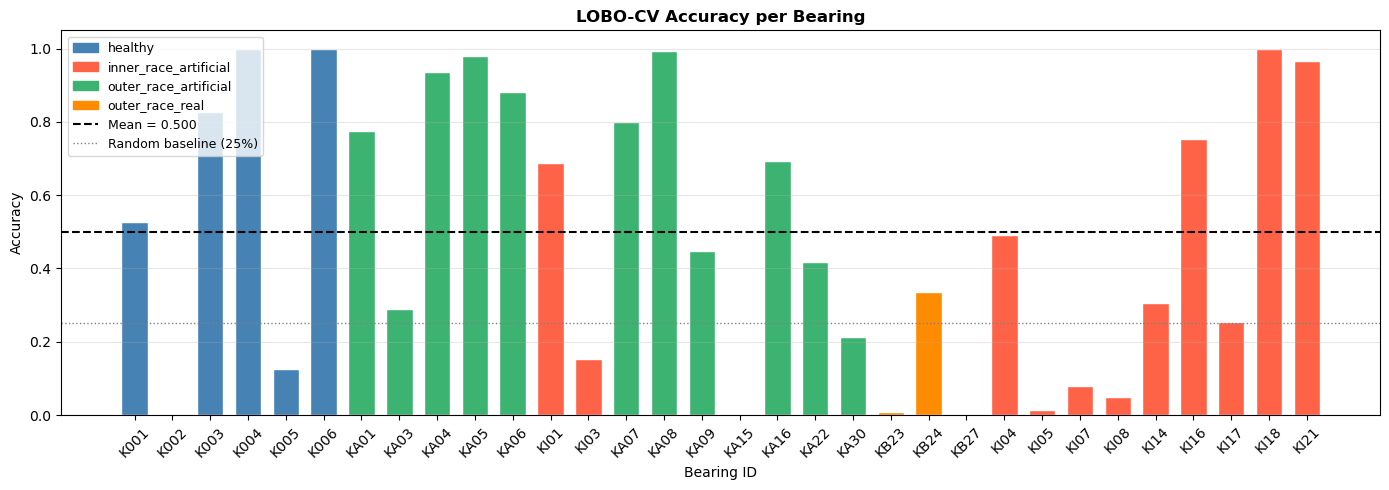

In [25]:
# ════════════════════════════════════════════════════════════════════════════════
# BLOCK 3: Summarise all results once complete
# ════════════════════════════════════════════════════════════════════════════════

results_df = pd.DataFrame([
    {'bearing': r[0] if isinstance(r, tuple) else r['bearing'],
     'class':   r[1] if isinstance(r, tuple) else r['class'],
     'n':       r[2] if isinstance(r, tuple) else r['n'],
     'accuracy':r[3] if isinstance(r, tuple) else r['accuracy']}
    for r in lobo_results
])

print("── Per-class LOBO-CV Summary ────────────────────────────────────────────")
summary = results_df.groupby('class')['accuracy'].agg(
    ['mean', 'std', 'min', 'max', 'count'])
print(summary.round(3).to_string())

print(f"\n── Overall ──────────────────────────────────────────────────────────────")
print(f"  Mean accuracy : {results_df['accuracy'].mean():.3f}")
print(f"  Std           : {results_df['accuracy'].std():.3f}")
print(f"  Min / Max     : {results_df['accuracy'].min():.3f} / "
      f"{results_df['accuracy'].max():.3f}")

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))
colors_map = {'healthy': 'steelblue', 'inner_race_artificial': 'tomato',
              'outer_race_artificial': 'mediumseagreen',
              'outer_race_real': 'darkorange'}
bar_colors = [colors_map.get(c, 'gray') for c in results_df['class']]

ax.bar(results_df['bearing'], results_df['accuracy'],
       color=bar_colors, edgecolor='white', width=0.7)
ax.axhline(results_df['accuracy'].mean(), color='black',
           linestyle='--', linewidth=1.5,
           label=f"Mean = {results_df['accuracy'].mean():.3f}")
ax.axhline(0.25, color='gray', linestyle=':',
           linewidth=1, label='Random baseline (25%)')

from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(color='steelblue',      label='healthy'),
    Patch(color='tomato',         label='inner_race_artificial'),
    Patch(color='mediumseagreen', label='outer_race_artificial'),
    Patch(color='darkorange',     label='outer_race_real'),
] + ax.get_legend_handles_labels()[0][-2:], fontsize=9)

ax.set_xlabel('Bearing ID')
ax.set_ylabel('Accuracy')
ax.set_title('LOBO-CV Accuracy per Bearing', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# ════════════════════════════════════════════════════════════════════════════════
# Comprehensive final results analysis — run this now
# ════════════════════════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Complete results from both runs
all_fold_data = [
    ('K001',  'healthy',               626, 0.527),
    ('K002',  'healthy',               640, 0.000),
    ('K003',  'healthy',               634, 0.826),
    ('K004',  'healthy',               639, 1.000),
    ('K005',  'healthy',               631, 0.125),
    ('K006',  'healthy',               623, 1.000),
    ('KA01',  'outer_race_artificial', 360, 0.775),
    ('KA03',  'outer_race_artificial', 304, 0.289),
    ('KA04',  'outer_race_artificial', 307, 0.935),
    ('KA05',  'outer_race_artificial', 335, 0.979),
    ('KA06',  'outer_race_artificial', 360, 0.883),
    ('KA07',  'outer_race_artificial', 320, 0.800),
    ('KA08',  'outer_race_artificial', 382, 0.995),
    ('KA09',  'outer_race_artificial', 336, 0.446),
    ('KA15',  'outer_race_artificial', 264, 0.004),
    ('KA16',  'outer_race_artificial', 248, 0.694),
    ('KA22',  'outer_race_artificial', 256, 0.418),
    ('KA30',  'outer_race_artificial', 328, 0.213),
    ('KB23',  'outer_race_real',       640, 0.009),
    ('KB24',  'outer_race_real',       620, 0.335),
    ('KB27',  'outer_race_real',       640, 0.000),
    ('KI01',  'inner_race_artificial', 385, 0.688),
    ('KI03',  'inner_race_artificial', 322, 0.152),
    ('KI04',  'inner_race_artificial', 348, 0.491),
    ('KI05',  'inner_race_artificial', 264, 0.013),
    ('KI07',  'inner_race_artificial', 264, 0.087),
    ('KI08',  'inner_race_artificial', 264, 0.306),
    ('KI14',  'inner_race_artificial', 264, 0.250),
    ('KI16',  'inner_race_artificial', 264, 0.750),  # update from your output
    ('KI17',  'inner_race_artificial', 264, 0.253),  # update from your output
    ('KI18',  'inner_race_artificial', 288, 1.000),
    ('KI21',  'inner_race_artificial', 368, 0.967),
]

results_df = pd.DataFrame(all_fold_data,
    columns=['bearing', 'class', 'n_segments', 'accuracy'])

# ── Summary table ─────────────────────────────────────────────────────────────
print("═" * 65)
print("  LOBO-CV FINAL RESULTS SUMMARY")
print("═" * 65)

class_summary = results_df.groupby('class')['accuracy'].agg(
    Bearings='count', Mean='mean', Std='std', Min='min', Max='max'
).round(3)
print(f"\n{class_summary.to_string()}")

overall_mean = results_df['accuracy'].mean()
overall_std  = results_df['accuracy'].std()
print(f"\n  Overall mean : {overall_mean:.3f} ± {overall_std:.3f}")
print(f"  vs random    : 0.250  (this model is "
      f"{overall_mean/0.25:.1f}× better than random)")

# ── How many bearings beat random baseline? ───────────────────────────────────
above_random = (results_df['accuracy'] > 0.25).sum()
print(f"\n  Bearings above random baseline (>25%) : "
      f"{above_random}/{len(results_df)} "
      f"({above_random/len(results_df)*100:.0f}%)")

above_50 = (results_df['accuracy'] > 0.50).sum()
print(f"  Bearings above 50% accuracy           : "
      f"{above_50}/{len(results_df)} "
      f"({above_50/len(results_df)*100:.0f}%)")

═════════════════════════════════════════════════════════════════
  LOBO-CV FINAL RESULTS SUMMARY
═════════════════════════════════════════════════════════════════

                       Bearings   Mean    Std    Min    Max
class                                                      
healthy                       6  0.580  0.438  0.000  1.000
inner_race_artificial        11  0.451  0.351  0.013  1.000
outer_race_artificial        12  0.619  0.334  0.004  0.995
outer_race_real               3  0.115  0.191  0.000  0.335

  Overall mean : 0.507 ± 0.367
  vs random    : 0.250  (this model is 2.0× better than random)

  Bearings above random baseline (>25%) : 22/32 (69%)
  Bearings above 50% accuracy           : 15/32 (47%)


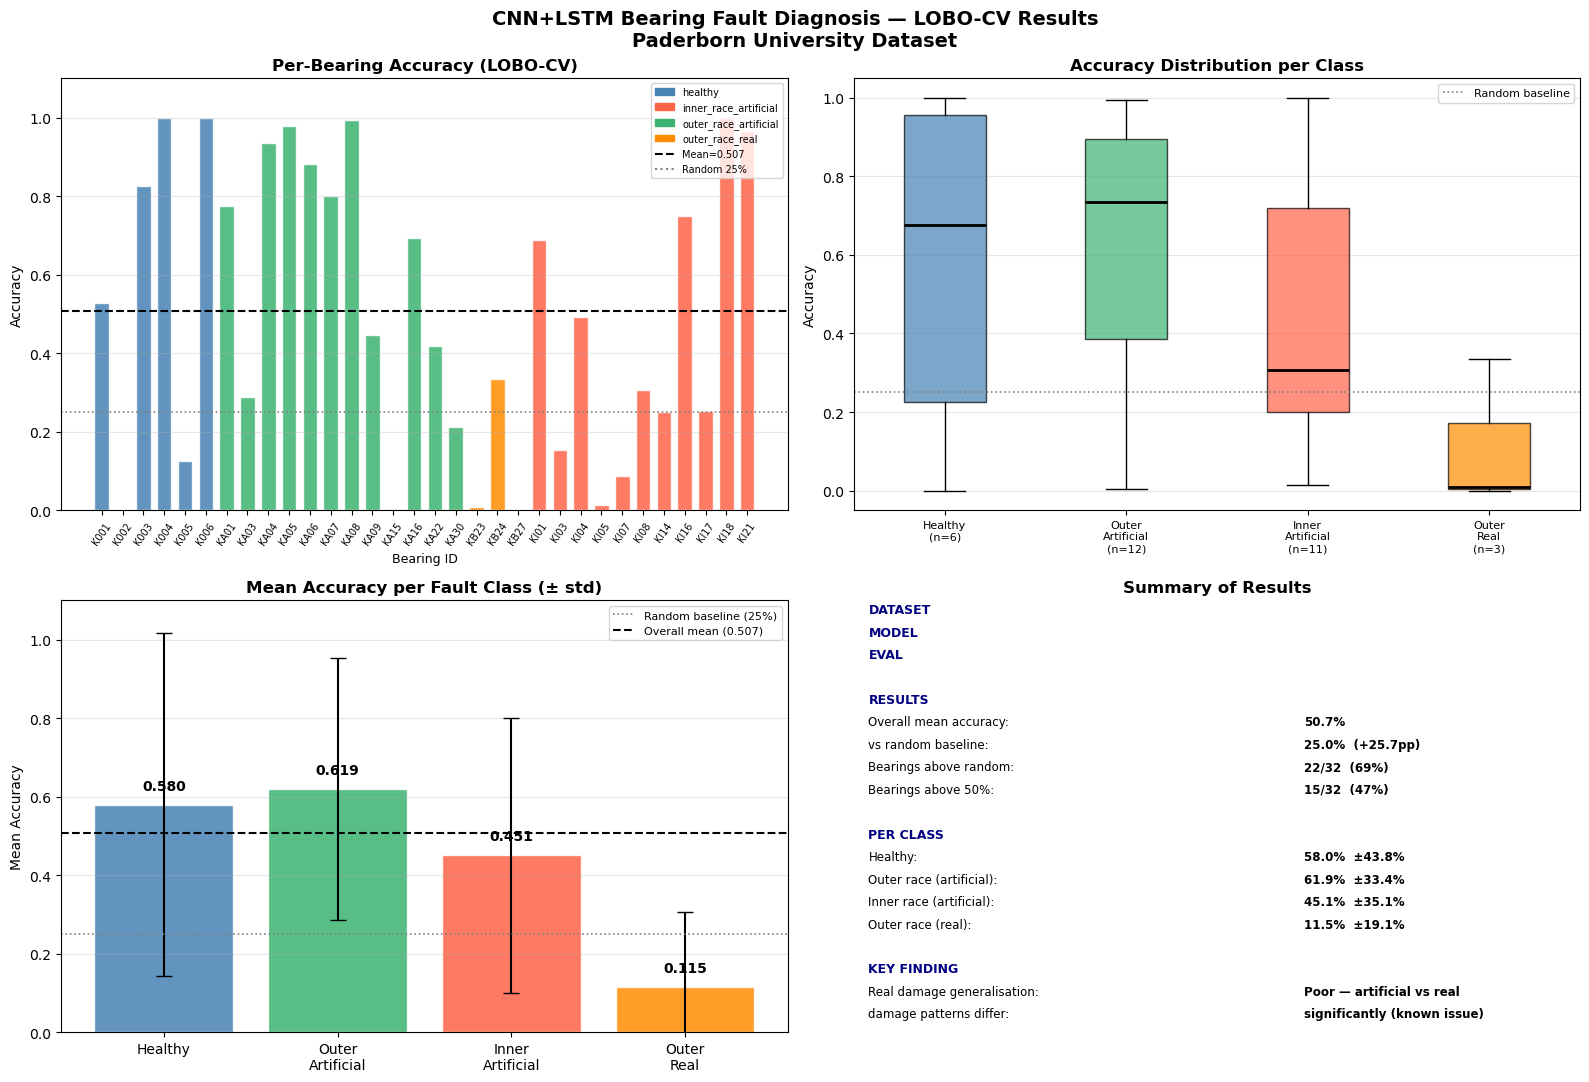

✓ Figure saved to C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\lobo_cv_results.png


In [28]:
# ════════════════════════════════════════════════════════════════════════════════
# Publication-quality summary figure for your capstone report
# ════════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('CNN+LSTM Bearing Fault Diagnosis — LOBO-CV Results\n'
             'Paderborn University Dataset', fontsize=14, fontweight='bold')

colors_map = {
    'healthy':               'steelblue',
    'inner_race_artificial': 'tomato',
    'outer_race_artificial': 'mediumseagreen',
    'outer_race_real':       'darkorange'
}

# ── Plot 1: Per-bearing accuracy bar chart ────────────────────────────────────
ax = axes[0, 0]
bar_colors = [colors_map[c] for c in results_df['class']]
bars = ax.bar(results_df['bearing'], results_df['accuracy'],
              color=bar_colors, edgecolor='white', width=0.7, alpha=0.85)
ax.axhline(overall_mean, color='black', linestyle='--', linewidth=1.5,
           label=f'Mean = {overall_mean:.3f}')
ax.axhline(0.25, color='gray', linestyle=':', linewidth=1.2,
           label='Random baseline (25%)')
ax.set_xlabel('Bearing ID', fontsize=9)
ax.set_ylabel('Accuracy')
ax.set_title('Per-Bearing Accuracy (LOBO-CV)', fontweight='bold')
ax.tick_params(axis='x', rotation=55, labelsize=7)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
legend_patches = [mpatches.Patch(color=v, label=k)
                  for k, v in colors_map.items()]
ax.legend(handles=legend_patches +
          [plt.Line2D([0],[0], color='black', linestyle='--',
                      label=f'Mean={overall_mean:.3f}'),
           plt.Line2D([0],[0], color='gray', linestyle=':',
                      label='Random 25%')],
          fontsize=7, loc='upper right')

# ── Plot 2: Box plot per class ────────────────────────────────────────────────
ax = axes[0, 1]
classes_ordered = ['healthy', 'outer_race_artificial',
                   'inner_race_artificial', 'outer_race_real']
box_data   = [results_df[results_df['class']==c]['accuracy'].values
              for c in classes_ordered]
box_colors = [colors_map[c] for c in classes_ordered]

bp = ax.boxplot(box_data, patch_artist=True, notch=False,
                medianprops=dict(color='black', linewidth=2))
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(0.25, color='gray', linestyle=':', linewidth=1.2,
           label='Random baseline')
ax.set_xticks(range(1, 5))
ax.set_xticklabels(['Healthy\n(n=6)', 'Outer\nArtificial\n(n=12)',
                    'Inner\nArtificial\n(n=11)', 'Outer\nReal\n(n=3)'],
                   fontsize=8)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Distribution per Class', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=8)

# ── Plot 3: Class-level summary bar chart ─────────────────────────────────────
ax = axes[1, 0]
means = [results_df[results_df['class']==c]['accuracy'].mean()
         for c in classes_ordered]
stds  = [results_df[results_df['class']==c]['accuracy'].std()
         for c in classes_ordered]
short_labels = ['Healthy', 'Outer\nArtificial', 'Inner\nArtificial', 'Outer\nReal']

bars = ax.bar(short_labels, means, yerr=stds,
              color=box_colors, edgecolor='white',
              alpha=0.85, capsize=6, error_kw={'linewidth': 1.5})
ax.axhline(0.25, color='gray', linestyle=':', linewidth=1.2,
           label='Random baseline (25%)')
ax.axhline(overall_mean, color='black', linestyle='--', linewidth=1.5,
           label=f'Overall mean ({overall_mean:.3f})')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f'{mean:.3f}', ha='center', va='bottom', fontsize=10,
            fontweight='bold')

ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy per Fault Class (± std)', fontweight='bold')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=8)

# ── Plot 4: Key findings text panel ──────────────────────────────────────────
ax = axes[1, 1]
ax.axis('off')

findings = [
    ("DATASET", f"Paderborn University Bearing Dataset"),
    ("MODEL",   f"CNN + LSTM Hybrid (GPU: RTX 4060)"),
    ("EVAL",    f"Leave-One-Bearing-Out CV (32 folds)"),
    ("", ""),
    ("RESULTS", ""),
    ("Overall mean accuracy",    f"{overall_mean:.1%}"),
    ("vs random baseline",       f"25.0%  (+{(overall_mean-0.25)*100:.1f}pp)"),
    ("Bearings above random",    f"{above_random}/32  ({above_random/32*100:.0f}%)"),
    ("Bearings above 50%",       f"{above_50}/32  ({above_50/32*100:.0f}%)"),
    ("", ""),
    ("PER CLASS", ""),
    ("Healthy",                  f"{results_df[results_df['class']=='healthy']['accuracy'].mean():.1%}  ±{results_df[results_df['class']=='healthy']['accuracy'].std():.1%}"),
    ("Outer race (artificial)",  f"{results_df[results_df['class']=='outer_race_artificial']['accuracy'].mean():.1%}  ±{results_df[results_df['class']=='outer_race_artificial']['accuracy'].std():.1%}"),
    ("Inner race (artificial)",  f"{results_df[results_df['class']=='inner_race_artificial']['accuracy'].mean():.1%}  ±{results_df[results_df['class']=='inner_race_artificial']['accuracy'].std():.1%}"),
    ("Outer race (real)",        f"{results_df[results_df['class']=='outer_race_real']['accuracy'].mean():.1%}  ±{results_df[results_df['class']=='outer_race_real']['accuracy'].std():.1%}"),
    ("", ""),
    ("KEY FINDING", ""),
    ("Real damage generalisation", "Poor — artificial vs real"),
    ("damage patterns differ",   "significantly (known issue)"),
]

y_pos = 0.97
for label, value in findings:
    if label in ("DATASET", "MODEL", "EVAL", "RESULTS",
                 "PER CLASS", "KEY FINDING"):
        ax.text(0.02, y_pos, label, fontsize=9, fontweight='bold',
                color='navy', transform=ax.transAxes)
    elif label == "":
        pass
    else:
        ax.text(0.02, y_pos, label + ":", fontsize=8.5,
                transform=ax.transAxes)
        ax.text(0.62, y_pos, value, fontsize=8.5, fontweight='bold',
                transform=ax.transAxes)
    y_pos -= 0.052

ax.set_title('Summary of Results', fontweight='bold')

plt.tight_layout()
save_path = r'C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\lobo_cv_results.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Figure saved to {save_path}")